In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import boto3
import datetime
import statsmodels.api as sm
import ruptures as rpt
#import geopandas
#from shapely.geometry import Point, LineString
#from shapely import wkt

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import fun_eda, fun_s3

In [3]:
##### Load dictionario tiles - ageb
DICT_TILES_AGEB = "~/bj/data/rutas_tiles/id_tiles_ageb.csv"
dict_tiles_ageb = pd.read_csv(DICT_TILES_AGEB) 

In [4]:
##### Load datos de movilidad en tiles
bucket_name = 'movicovid'
fname = '{}/{}/{}'.format('raw', 'tiles_ageb', 'movimiento_tiles_19072020.csv')
data_tiles = fun_s3.abre_file_como_df(bucket_name, fname)

In [5]:
print("Num de registros: {:0,.0f}".format(data_tiles.shape[0]))
data_tiles.head(3)

Num de registros: 3,286,785


geometry            date_time  \
0  LINESTRING (-99.04174804687501 19.362975803871...  2020-03-17 00:00:00   
1  LINESTRING (-99.04174804687501 19.362975803871...  2020-03-17 00:00:00   
2  LINESTRING (-99.04174804687501 19.362975803871...  2020-03-17 00:00:00   

   start_polygon_id start_polygon_name  end_polygon_id end_polygon_name  \
0            589187         Iztapalapa          589187       Iztapalapa   
1            589187         Iztapalapa          589187       Iztapalapa   
2            589187         Iztapalapa          590171   Nezahualcóyotl   

   length_km  tile_size country   level  ...  percent_change  \
0   4.610109         14      MX  LEVEL3  ...      -18.181818   
1   5.154586         14      MX  LEVEL3  ...      -32.160804   
2   5.153930         14      MX  LEVEL3  ...      -51.127820   

   is_statistically_significant   z_score  start_lat  start_lon    end_lat  \
0                             0 -0.648886  19.349192 -99.056864  19.349192   
1                             0 -1.780183  19.349192 -99.056864  19.349192   
2                             0 -1.936937  19.349192 -99.056864  19.422548   

     end_lon  start_quadkey    end_quadkey  \
0 -99.056864  2331003322302  2331003322312   
1 -99.056864  2331003322302  2331003322330   
2 -99.023699  2331003322302  2331003322310   

                                               fecha  
0  ./inp/tiles/21072020/Mexico City Coronavirus D...  
1  ./inp/tiles/21072020/Mexico City Coronavirus D...  
2  ./inp/tiles/21072020/Mexico City Coronavirus D...  

[3 rows x 23 columns]

In [6]:
# Separamos fecha y hora
data_tiles[['fecha', 'hora']] = data_tiles['date_time'].str.split(' ', 2, expand=True)
####################################   CAMBIO TIPO DE VARIABLES
data_tiles['start_polygon_name'] = data_tiles['start_polygon_name'].astype('category')
data_tiles['end_polygon_name'] = data_tiles['end_polygon_name'].astype('category')
data_tiles['fecha'] = pd.to_datetime(data_tiles['fecha'])
data_tiles['hr'] = data_tiles['hora'].str.slice(start=0, stop=2).astype(int)
### Añado una columna que contabilice el numero de semanas
data_tiles['num_semana'] = data_tiles['fecha'].dt.week
### Añado una columna para el dia de la semana
dict_days = {0:'Lunes',1:'Martes',2:'Miércoles',3:'Jueves',4:'Viernes',5:'Sábado',6:'Domingo'}
data_tiles['dia_semana'] = data_tiles['fecha'].dt.dayofweek.map(dict_days)
# Separamos las coordenadas
data_tiles['geometry'] = data_tiles['geometry'].str.replace('LINESTRING',"").str.strip()
data_tiles[['origen', 'destino']] = data_tiles['geometry'].astype(str).str.replace("(", "").str.replace(")","").str.strip().str.split(',', 2, expand=True)
data_tiles[['origen_long', 'origen_lat']] = data_tiles['origen'].str.strip().str.split(' ', 2, expand=True).astype('float64').round(8).astype('str')
data_tiles[['destino_long', 'destino_lat']] = data_tiles['destino'].str.strip().str.split(' ', 2, expand=True).astype('float64').round(8).astype('str')
#data_tiles.columns

In [7]:
data_tiles['coord_origen'] = data_tiles['origen_long'] + ' ' + data_tiles['origen_lat']
data_tiles['coord_destino'] = data_tiles['destino_long'] + ' ' + data_tiles['destino_lat']

In [8]:
print(dict_tiles_ageb.shape)
dict_tiles_ageb['coord'] = dict_tiles_ageb['long'].astype(str) + ' ' + dict_tiles_ageb['lat'].astype(str)
dict_tiles_ageb['ageb'] = dict_tiles_ageb['CVE_AGEB'].astype('str').str.zfill(4)
dict_ageb = dict(zip(dict_tiles_ageb.coord, dict_tiles_ageb.ageb))
dict_tiles_ageb.head(5)
###
# Cleve AGEB completa 23 digitos (str)
# que es id?
# tipo para manejar las coordenadas (float, string, cat?)


(5743, 4)


long        lat   id CVE_AGEB                     coord  ageb
0 -99.305420  19.362976  411      335   -99.30541992 19.3629758  0335
1 -99.283447  19.321511  386      157   -99.28344727 19.3215109  0157
2 -99.239502  19.217803  324      368  -99.23950195 19.21780263  0368
3 -99.151611  19.155546  151     1250  -99.15161133 19.15554622  1250
4 -99.129639  19.197053  125     1829  -99.12963867 19.19705311  1829

In [9]:
print(dict_tiles_ageb['coord'].unique().shape, data_tiles['coord_origen'].unique().shape, data_tiles['coord_destino'].unique().shape )

(605,) (727,) (727,)


In [10]:
data_tiles['AGEB_origen'] = data_tiles['coord_origen'].map(dict_ageb)
data_tiles['AGEB_destino'] = data_tiles['coord_destino'].map(dict_ageb)

In [11]:
data_tiles['ruta'] = data_tiles['AGEB_origen'].astype('str') + ' - ' + data_tiles['AGEB_destino'].astype('str')

In [12]:
####################################     INTER-RUTAS
# Rutas entre alcaldias/municipios
data_tiles = data_tiles[data_tiles['coord_origen']!=data_tiles['coord_destino']]
print(data_tiles.shape)
# *NO hay rutas en el mismo tile

(3026145, 38)


In [13]:
####################################     DATAFRAMES
### Hacemos df por ventana de tiempo 
df_tiles = data_tiles[['ruta', 'geometry', 'start_polygon_name', 'end_polygon_name', 'length_km', 'n_crisis', 'n_baseline', 
                 'n_difference', 'percent_change', 'fecha', 'hora', 'hr', 'num_semana', 'dia_semana','origen', 'destino',
                 'origen_long', 'origen_lat', 'destino_long', 'destino_lat']]
    
rutas_8hr =df_tiles.loc[data_tiles['hr']==8].reset_index(drop=True).copy()
rutas_16hr = df_tiles.loc[data_tiles['hr']==16].reset_index(drop=True).copy()
rutas_0hr = df_tiles.loc[data_tiles['hr']==0].reset_index(drop=True).copy()

In [14]:
# Total de registros por ventana de tiempo
a = rutas_8hr.shape[0]
b = rutas_16hr.shape[0]
c = rutas_0hr.shape[0]
print('Total registros: {:0,.0f}'.format(a+b+c))
print('08 hrs: {:0,.0f} \n16 hrs: {:0,.0f} \n00 hrs: {:0,.0f}'.format(a, b, c))
print()
# Rutas en tiles por ventana de tiempo
a = rutas_8hr['geometry'].unique().shape[0]
b = rutas_16hr['geometry'].unique().shape[0]
c = rutas_0hr['geometry'].unique().shape[0]
print("Rutas en coordenadas: {:0,.0f}".format(a+b+c))
print("08 hrs: {:0,.0f} \n16 hrs: {:0,.0f} \n00 hrs: {:0,.0f}".format(a,b,c))

# Rutas en tiles por ventana de tiempo
a = rutas_8hr['ruta'].unique().shape[0]
b = rutas_16hr['ruta'].unique().shape[0]
c = rutas_0hr['ruta'].unique().shape[0]
print("Rutas en tiles: {:0,.0f}".format(a+b+c))
print("08 hrs: {:0,.0f} \n16 hrs: {:0,.0f} \n00 hrs: {:0,.0f}".format(a,b,c))

Total registros: 3,026,145
08 hrs: 800,561 
16 hrs: 968,395 
00 hrs: 1,257,189

Rutas en coordenadas: 52,803
08 hrs: 14,849 
16 hrs: 17,039 
00 hrs: 20,915
Rutas en tiles: 52,208
08 hrs: 14,736 
16 hrs: 16,866 
00 hrs: 20,606


In [15]:
# Funcion para determinar las rutas que pertenecen a los grupos
# los grupos se calculan con base al promedio a partir del 23 de Marzo
def rutas_con_reduccion_menor_al_thr(df_rutas, threshold):
    
    # Calculamos el promedio de cambio a partir del 23 de marzo
    avg_change = df_rutas.loc[:,'2020-03-23':].mean(axis=1, skipna=True)
    # Obtenemos los index de las rutas mayores al threshold
    avg_change_index = avg_change[avg_change>=threshold].index
    # Obtenemos la base cuyo promedio es mayor al threshold
    grupo = df_rutas.loc[avg_change_index]

    return grupo

In [16]:
def bins_para_graficar(df_rutas, threshold, step):
    grupo = []
    
    # Calculamos el promedio de cambio a partir del 23 de marzo
    avg_change = df_rutas.loc[:,'2020-03-23':].mean(axis=1, skipna=True)
    
    bins =  range(threshold, -threshold+1, step)
    # Encontramos los cuartiles
    grupos = pd.cut(avg_change, bins)
    
      
    for cat in grupos.cat.categories:
        index_grupo =  grupos[grupos == cat].index
        grupo_cat = df_rutas.loc[index_grupo]
        grupo.append(grupo_cat)

    return grupo, grupos.cat.categories

In [17]:
def grafica_cambio_en_en_tiempo_grupos_estatica(df_grupo, rutas, subtitulo):
    #df_grupo: df que contiene las rutas
    #rutas: array con los nombres de las rutas
    #dias: array con los dias del periodo
    #group_name: str con el nombre del grupo
    #flag: para cambiar el titulo
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(20,10))
    
    for ruta in rutas:
        ax.plot(df_grupo.loc[ruta])
    plt.axhline(y=0, color='red', linestyle='solid')
    
    myFmt = DateFormatter("%d-%b-%Y")
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(DayLocator(interval=5))
    ax.xaxis.set_minor_locator(DayLocator())
    
    plt.title('{} rutas con reducciones promedio en el intervalo {}'.format(subtitulo[0], subtitulo[1]), fontsize=16)
        
    plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='14')
    
   # plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
   # plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')
    
    plt.xticks(fontsize='14', rotation='vertical')
    plt.yticks(fontsize='14')
    plt.show()

In [18]:
# Graficas por grupos
# Cambio porcentual diario por ruta, todo el periodo
#rutas = grupo1.index
#dias = grupo1.columns

def grafica_cambio_en_en_tiempo_grupos(df_grupo, rutas, subtitulo):
    #df_grupo: df que contiene las rutas
    #rutas: array con los nombres de las rutas
    #dias: array con los dias del periodo
    #group_name: str con el nombre del grupo
    #flag: para cambiar el titulo
    
    fig = go.Figure()
        
    for ruta in rutas:
        #ax.plot(df_grupo.loc[ruta])
        fig.add_trace(go.Scatter(x=df_grupo.columns, y=df_grupo.loc[ruta], name=ruta, hovertext=ruta))
        
        fig.add_shape(
            # Line Vertical
            dict(
                type="line",
                x0=datetime.datetime(2020, 3, 23),
                y0=min(df_grupo.loc[ruta]),
                x1=datetime.datetime(2020, 3, 23),
                y1=max(df_grupo.loc[ruta]),
                line=dict(
                color="Red",
                width=3)
        )
    )
        
    titulo = '{} rutas con reducciones promedio en el intervalo {}'.format(subtitulo[0], subtitulo[1])
        
    fig.update_layout( 
        yaxis = dict(
            tickmode = 'linear',
            tick0 = -100, #round(min(df_grupo.loc[ruta])) ,
            dtick = 10
            ),
        title=titulo,
        yaxis_title="Porcentaje de cambio con respecto al baseline",
        xaxis_title="Dias",
        #legend_title="Legend Title",
        font=dict(
            #family="Courier New, monospace",
            size=12,
            color="Black"),
        showlegend=False,
        autosize=False,
        width=1000,
        height=500,
    )    
    
    fig.show()

### Params

In [19]:
UMBRAL_CAMBIO_PORCENTUAL = -10
STD = 6
STEP = 2

fecha_ini = '2020-03-23'
fecha_fin = '2020-06-07'
fecha_ini_lag = '2020-04-01'
fecha_fin_lag = '2020-05-31'

In [20]:
dia_inicio = rutas_8hr['fecha'].min()
dia_final = rutas_8hr['fecha'].max()
dias_serie = pd.date_range(start=dia_inicio, end=dia_final, freq='D')
dias_serie

DatetimeIndex(['2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26',
               ...
               '2020-07-10', '2020-07-11', '2020-07-12', '2020-07-13',
               '2020-07-14', '2020-07-15', '2020-07-16', '2020-07-17',
               '2020-07-18', '2020-07-19'],
              dtype='datetime64[ns]', length=125, freq='D')


### 1. Rutas por tiles: 08 hrs

In [21]:
### Reshape
rutas_8hr_panel = rutas_8hr.groupby(['geometry', 'fecha']).mean()['percent_change'].unstack().transpose()
rutas_8hr_panel = rutas_8hr_panel.reindex(dias_serie)
rutas_8hr_panel = rutas_8hr_panel.transpose()

# Selecciono lo a ventana de tiempo
rutas_8hr_panel = rutas_8hr_panel.loc[:, fecha_ini:fecha_fin]
print(rutas_8hr_panel.shape)
#rutas_8hr_panel.head(3)

(14849, 77)


In [22]:
rutas_8hr_panel_lag = rutas_8hr_panel.loc[:, fecha_ini:fecha_fin_lag]
rutas_8hr_panel_lag.columns = rutas_8hr_panel.columns[7:]
#rutas_8hr_panel_lag.head(3)

In [23]:
rutas_8hr_panel_diff = rutas_8hr_panel - rutas_8hr_panel_lag
rutas_8hr_panel_diff.drop(rutas_8hr_panel_diff.columns[:7], axis=1, inplace=True)
rutas_8hr_panel_diff.dropna(how='all', axis=0, inplace=True)
print(rutas_8hr_panel_diff.shape)
#rutas_8hr_panel_diff.head(3)

(10035, 70)


In [24]:
stats = rutas_8hr_panel_diff.agg(['mean', 'max', 'min', 'std', 'count'], axis=1)
stats.head(5)

mean        max  \
(-98.75610351562499 19.508019823370297, -98.887...  -1.749591  23.529412   
(-98.756103515625 19.21780263228372, -98.778076...   1.584987  36.363636   
(-98.756103515625 19.21780263228372, -98.800048... -12.048193  -6.024096   
(-98.756103515625 19.21780263228372, -98.887939...   4.385965   8.771930   
(-98.756103515625 19.714999913710088, -98.75610...  -0.977996  44.871795   

                                                          min        std  \
(-98.75610351562499 19.508019823370297, -98.887... -25.974026  17.003452   
(-98.756103515625 19.21780263228372, -98.778076... -29.090909  21.352181   
(-98.756103515625 19.21780263228372, -98.800048... -18.072289   8.519359   
(-98.756103515625 19.21780263228372, -98.887939...   0.000000   6.202691   
(-98.756103515625 19.714999913710088, -98.75610... -60.810811  24.923703   

                                                    count  
(-98.75610351562499 19.508019823370297, -98.887...    7.0  
(-98.756103515625 19.21780263228372, -98.778076...   34.0  
(-98.756103515625 19.21780263228372, -98.800048...    2.0  
(-98.756103515625 19.21780263228372, -98.887939...    2.0  
(-98.756103515625 19.714999913710088, -98.75610...   53.0

In [25]:
stats_index = stats[(stats['mean']>=UMBRAL_CAMBIO_PORCENTUAL) & (stats['mean']<=-UMBRAL_CAMBIO_PORCENTUAL) &
      (stats['std']<= STD)  & (stats['max']<=-UMBRAL_CAMBIO_PORCENTUAL*2) & (stats['min']>=UMBRAL_CAMBIO_PORCENTUAL*2)].index
      #(stats['count']>=40)

# Obtenemos la base cuyo promedio es mayor al threshold
grupo = rutas_8hr_panel_diff.loc[stats_index]
#grupo

In [26]:
grupo_8h =  rutas_con_reduccion_menor_al_thr(grupo, UMBRAL_CAMBIO_PORCENTUAL)
print('Número de rutas con reducciones menores al {}% y mayores al {}: {:0,.0f}'.format(-UMBRAL_CAMBIO_PORCENTUAL, UMBRAL_CAMBIO_PORCENTUAL, grupo_8h.shape[0]))


Número de rutas con reducciones menores al 10% y mayores al -10: 539


In [27]:
grupos_grafica, subinterval = bins_para_graficar(grupo_8h, UMBRAL_CAMBIO_PORCENTUAL, STEP)

for i in range(0, len(grupos_grafica)):
    print("En el intervalo {} hay {:0,.0f} rutas".format(subinterval[i], grupos_grafica[i].shape[0]) )

En el intervalo (-10, -8] hay 23 rutas
En el intervalo (-8, -6] hay 23 rutas
En el intervalo (-6, -4] hay 34 rutas
En el intervalo (-4, -2] hay 77 rutas
En el intervalo (-2, 0] hay 197 rutas
En el intervalo (0, 2] hay 76 rutas
En el intervalo (2, 4] hay 66 rutas
En el intervalo (4, 6] hay 18 rutas
En el intervalo (6, 8] hay 20 rutas
En el intervalo (8, 10] hay 5 rutas


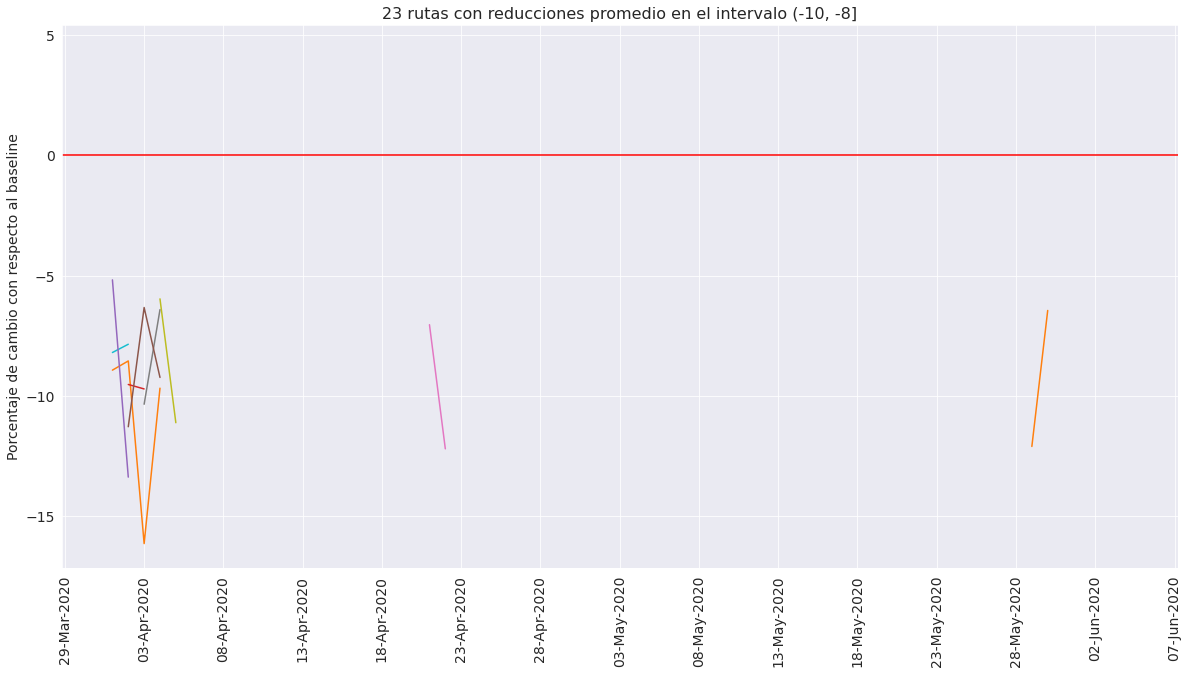

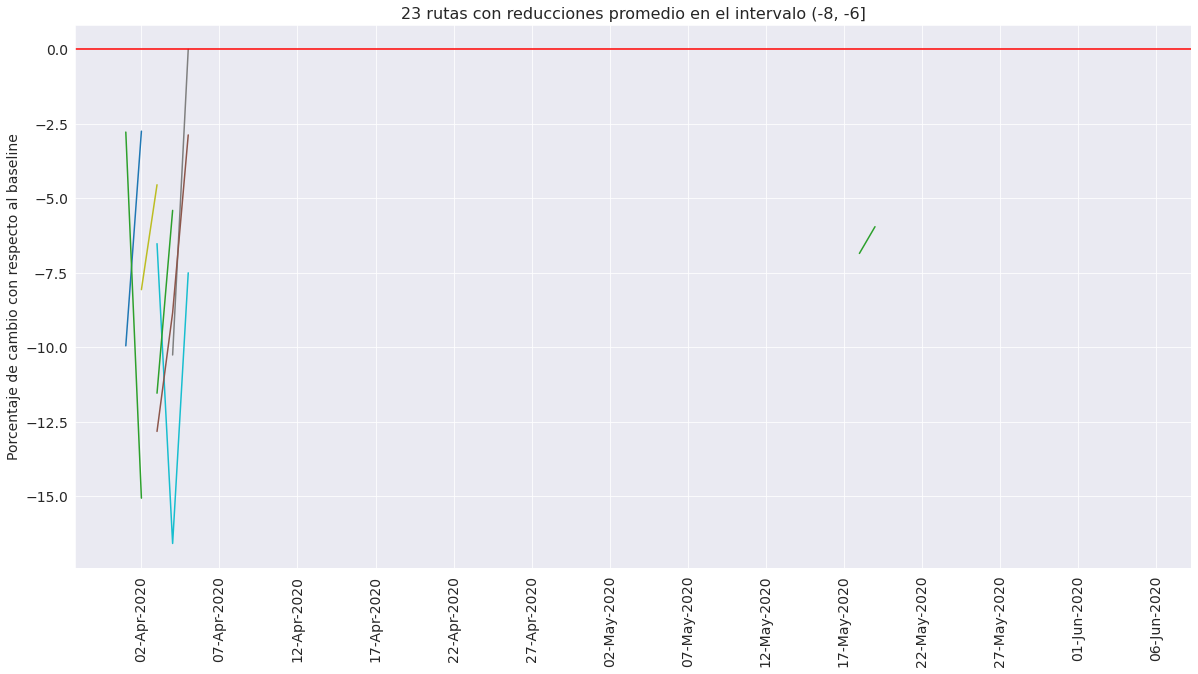

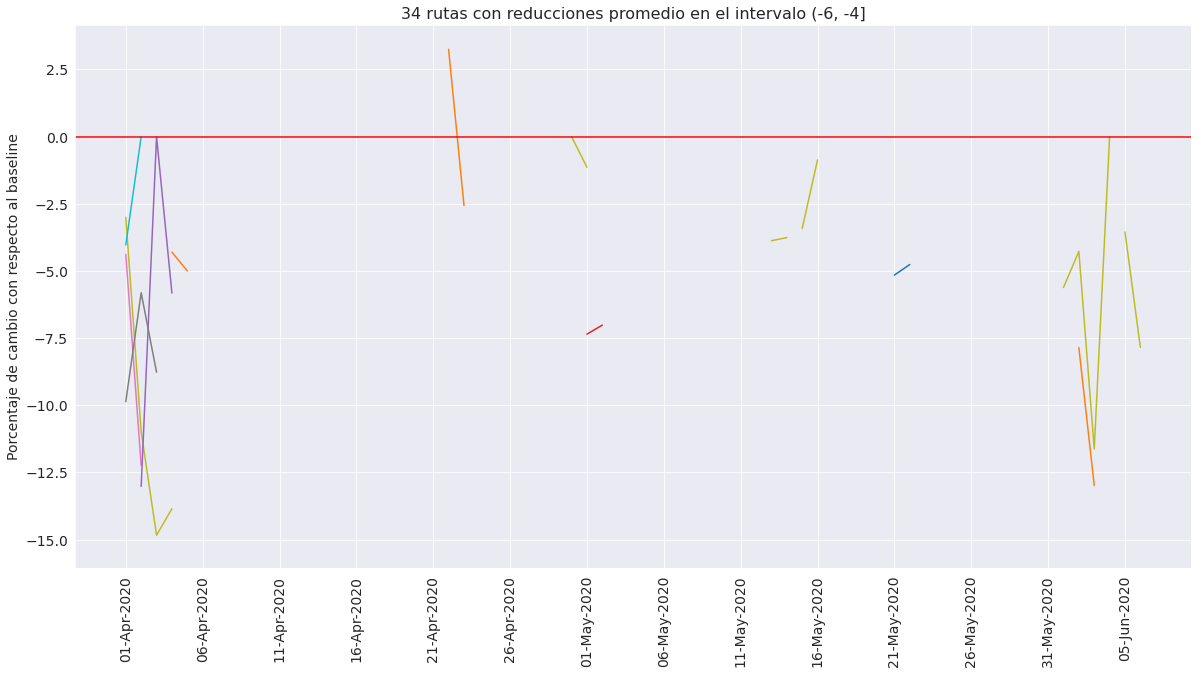

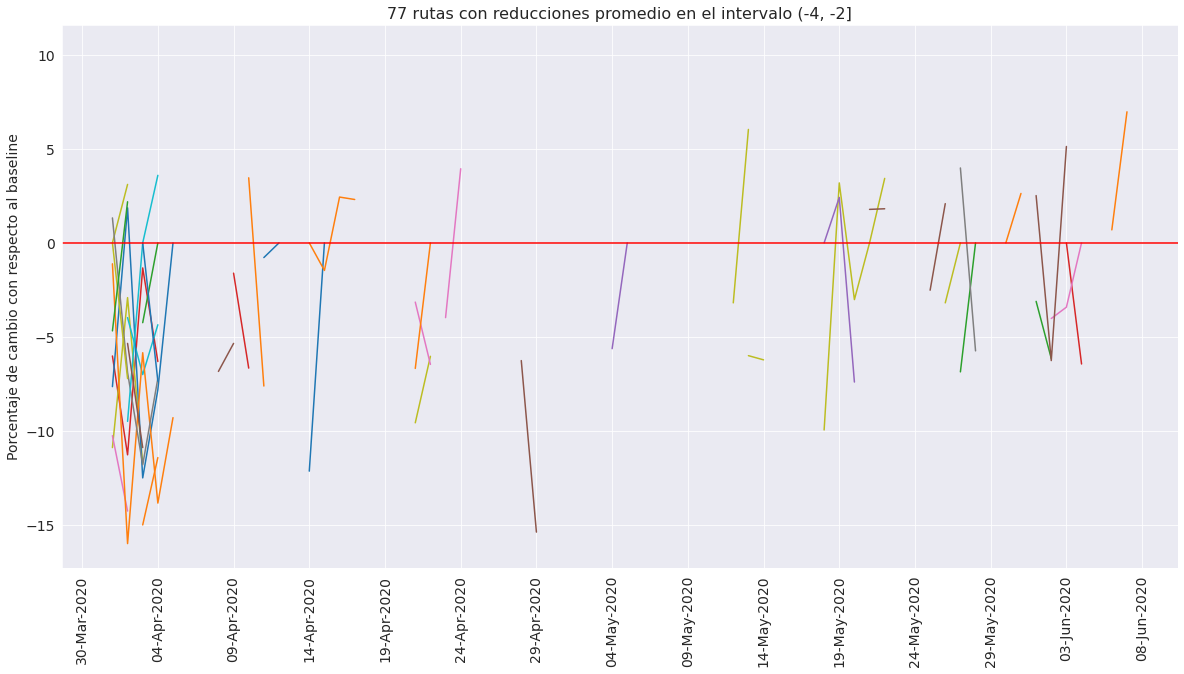

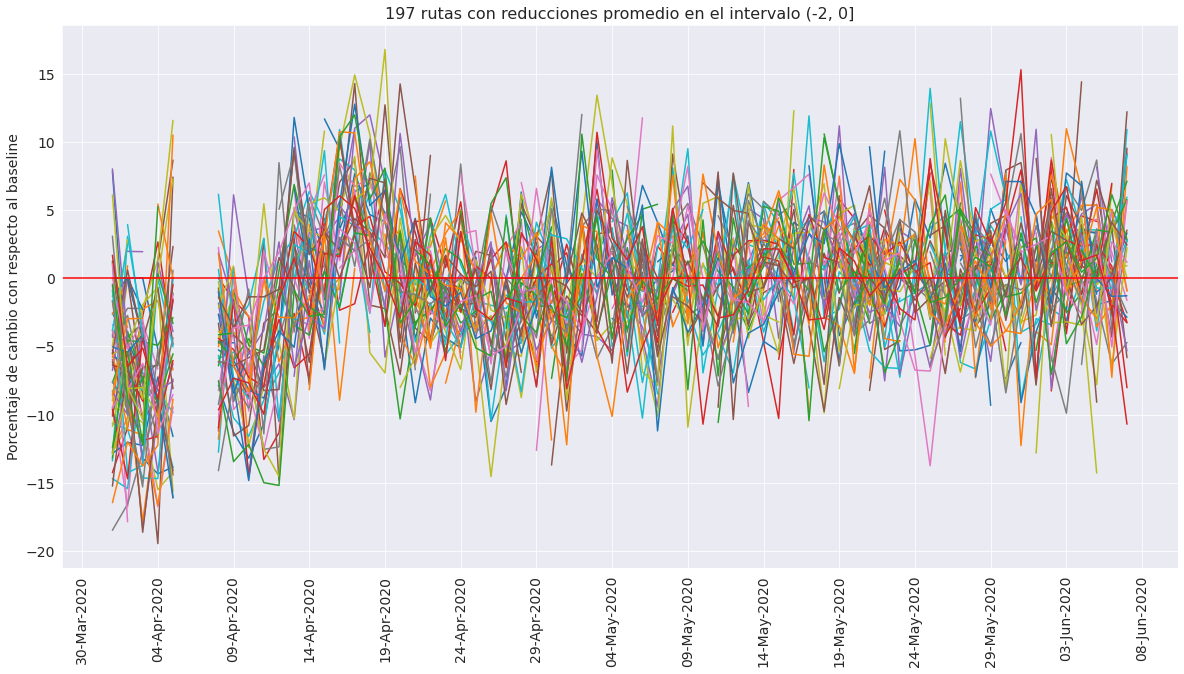

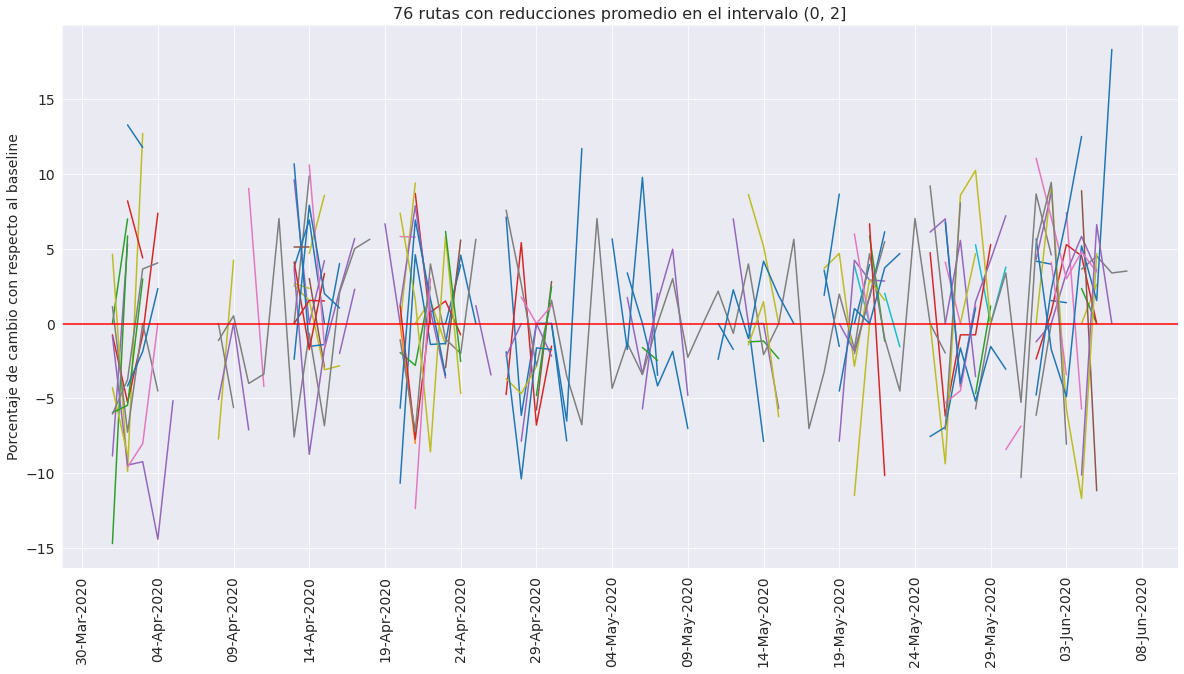

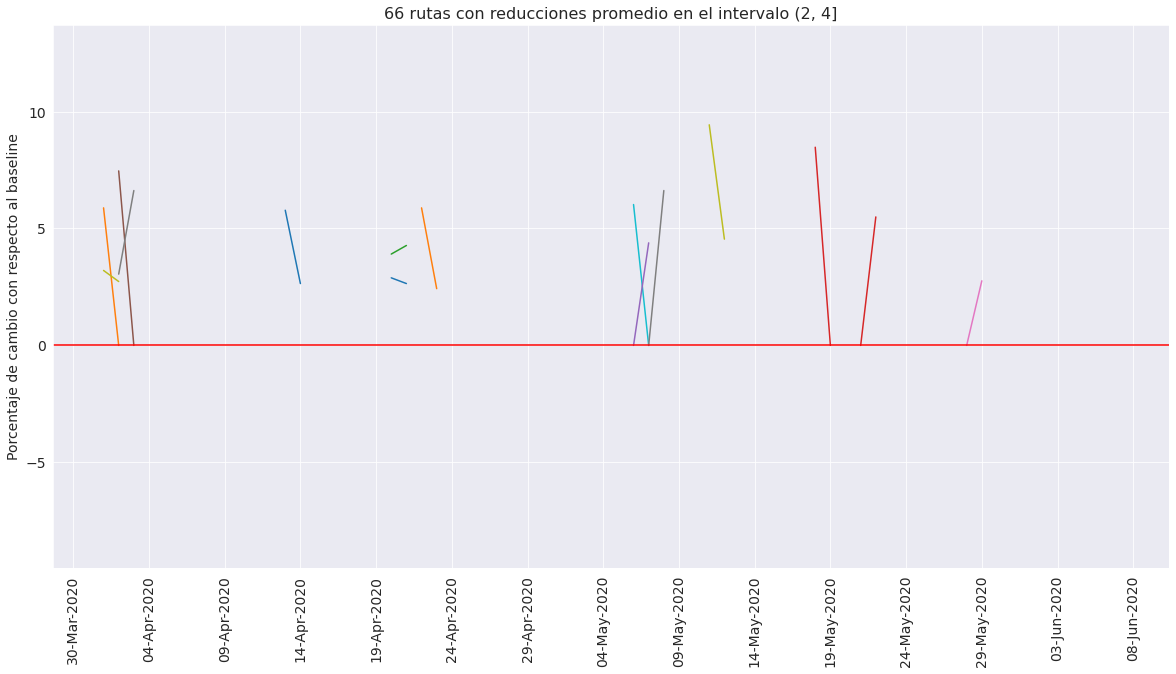

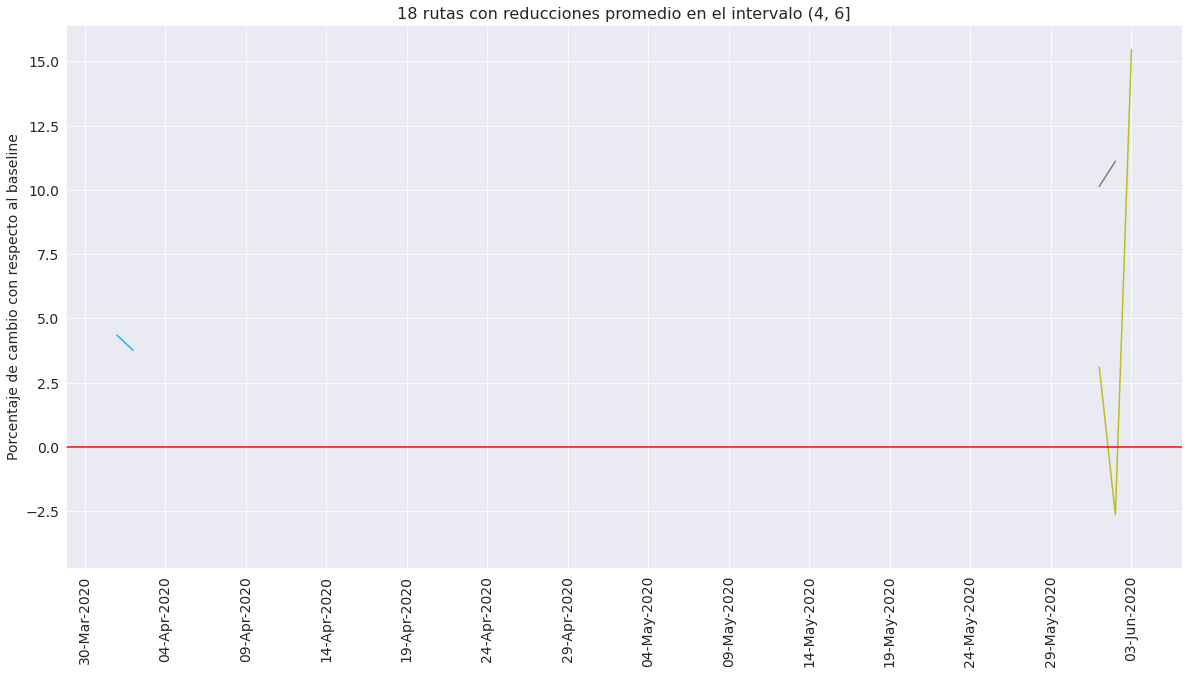

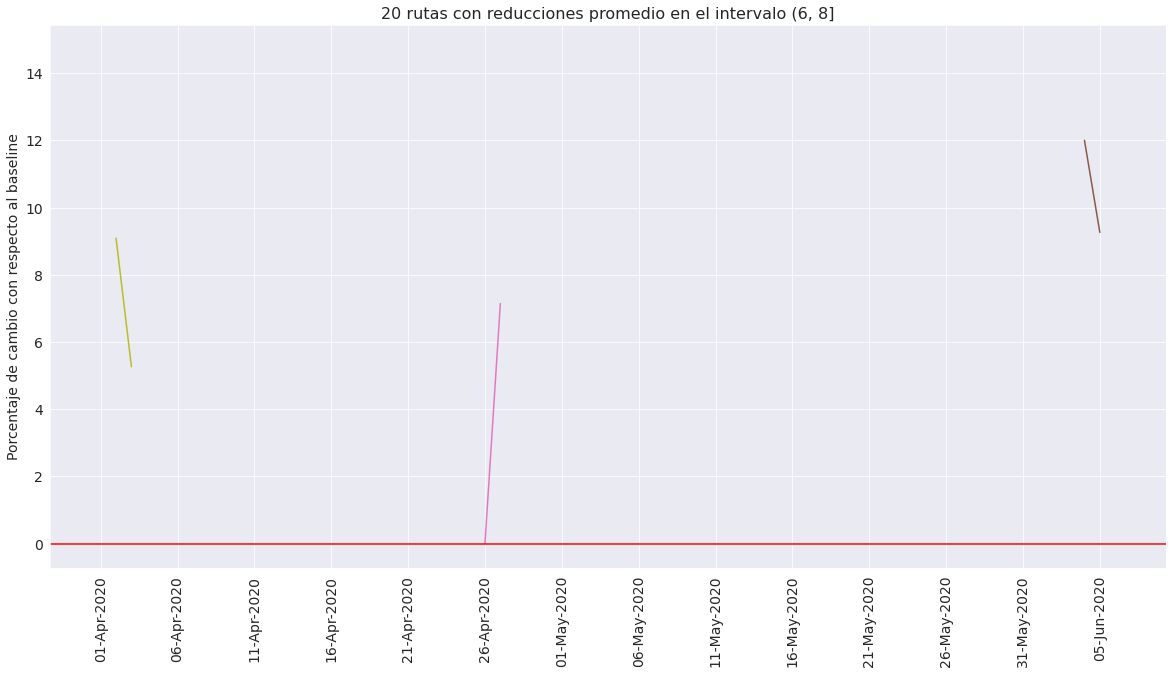

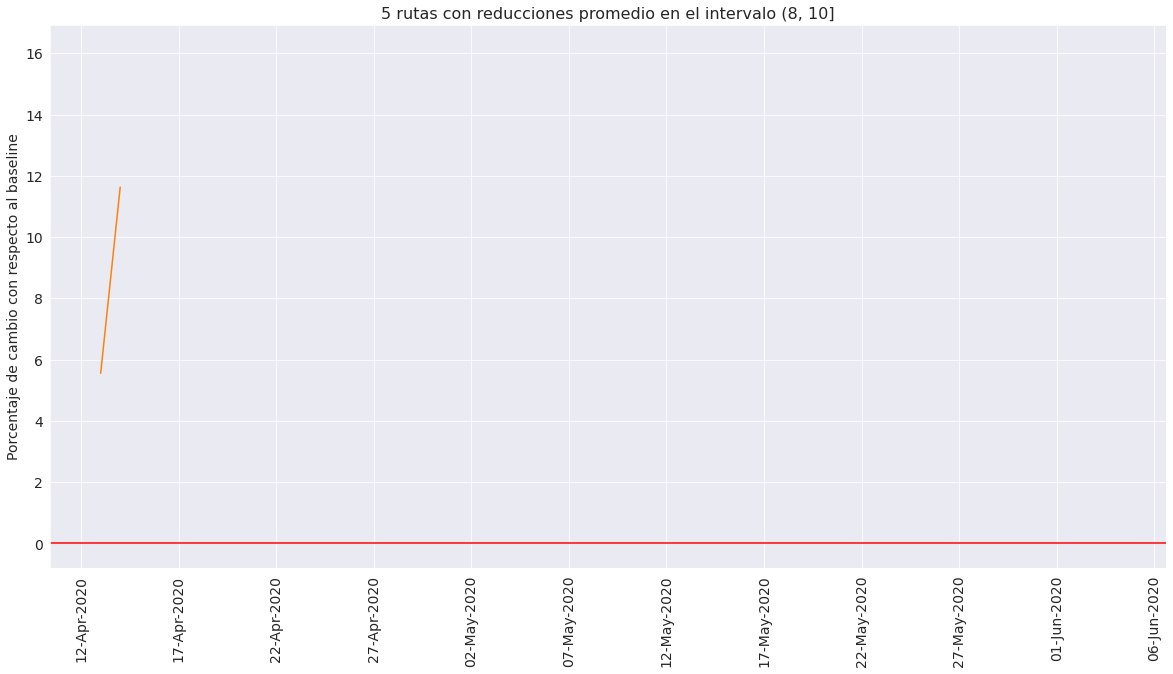

In [28]:
for i in range(0,len(grupos_grafica)):
    rutas = grupos_grafica[i].index 
    sub = [str(rutas.shape[0]), str(subinterval[i])]
    #grafica_cambio_en_en_tiempo_grupos(grupos_grafica[i], rutas, sub)
    grafica_cambio_en_en_tiempo_grupos_estatica(grupos_grafica[i], rutas, sub)

In [29]:
df = grupos_grafica[4]
df1 = df[df.isnull().sum(axis=1)<=20]
df1
df1.to_csv("~/bj/data/rutas_tiles/rutas_8hr.csv")

In [30]:
rutas = df1.index 
sub = [str(rutas.shape[0]), str(subinterval[4])]
grafica_cambio_en_en_tiempo_grupos(df1, rutas, sub)
#grafica_cambio_en_en_tiempo_grupos_estatica(grupos_grafica[i], rutas, sub)

In [31]:
## Numero de personas transitando esas 35 rutas
data_rutas_selected = data_tiles[data_tiles.geometry.isin(df1.index)]

rutas_8hr_selected = data_rutas_selected.groupby(['geometry', 'fecha']).mean()['n_crisis'].unstack()
print("Total de personas en las 35 rutas seleccionadas: {:0,.0f}".format(rutas_8hr_selected.sum(axis=1).sum(axis=0)))
print("Total de personas en todas las rutas: {:0,.0f}".format(rutas_8hr.groupby(['geometry', 'fecha']).mean()['n_crisis'].unstack().sum(axis=1).sum(axis=0)))

#rutas_8hr_selected.head(3)

Total de personas en las 35 rutas seleccionadas: 395,789
Total de personas en todas las rutas: 20,833,899


## CDP


In [32]:
idx = df1.index
rutas_8hr_panel_selected = rutas_8hr.groupby(['geometry', 'fecha']).mean()['n_difference'].unstack()
rutas_8hr_panel_selected = rutas_8hr_panel_selected[rutas_8hr_panel_selected.index.isin(idx)]
rutas_8hr_panel_selected = rutas_8hr_panel_selected.transpose()
rutas_8hr_panel_selected = rutas_8hr_panel_selected.reindex(dias_serie)

rutas_8hr_panel_selected

geometry    (-98.887939453125 19.508019823370297, -98.887939453125 19.487307187313725)  \
2020-03-17                                             -84.00                            
2020-03-18                                             -77.20                            
2020-03-19                                            -100.80                            
2020-03-20                                             -68.00                            
2020-03-21                                             -42.25                            
...                                                       ...                            
2020-07-15                                             -96.20                            
2020-07-16                                            -106.80                            
2020-07-17                                             -90.00                            
2020-07-18                                             -57.25                            
2020-07-19                                             -43.80                            

geometry    (-99.12963867187499 19.42515338859868, -99.15161132812499 19.42515338859868)  \
2020-03-17                                             -65.20                              
2020-03-18                                             -93.00                              
2020-03-19                                            -129.20                              
2020-03-20                                            -118.60                              
2020-03-21                                            -108.25                              
...                                                       ...                              
2020-07-15                                            -196.00                              
2020-07-16                                            -237.20                              
2020-07-17                                            -198.60                              
2020-07-18                                            -211.25                              
2020-07-19                                            -181.80                              

geometry    (-99.12963867187501 19.300774497281314, -99.12963867187501 19.280035468000158)  \
2020-03-17                                              -32.2                                
2020-03-18                                              -38.0                                
2020-03-19                                              -54.8                                
2020-03-20                                              -46.6                                
2020-03-21                                              -74.0                                
...                                                       ...                                
2020-07-15                                             -139.0                                
2020-07-16                                             -127.8                                
2020-07-17                                             -137.6                                
2020-07-18                                             -166.0                                
2020-07-19                                             -138.4                                

geometry    (-99.12963867187501 19.487307187313725, -99.129638671875 19.508019823370297)  \
2020-03-17                                             -113.4                              
2020-03-18                                              -91.2                              
2020-03-19                                             -126.2                              
2020-03-20                                             -103.4                              
2020-03-21                                              -94.0                              
...                                                       ...                              
2020-07-15                               

In [33]:
## rolling average
rolling_rutas_8hr_panel_selected = rutas_8hr_panel_selected.rolling(7).mean()
print(rolling_rutas_8hr_panel_selected.shape)
rolling_rutas_8hr_panel_selected.head(15)

(125, 34)


geometry    (-98.887939453125 19.508019823370297, -98.887939453125 19.487307187313725)  \
2020-03-17                                                NaN                            
2020-03-18                                                NaN                            
2020-03-19                                                NaN                            
2020-03-20                                                NaN                            
2020-03-21                                                NaN                            
2020-03-22                                                NaN                            
2020-03-23                                         -68.750000                            
2020-03-24                                         -70.178571                            
2020-03-25                                         -72.178571                            
2020-03-26                                         -71.607143                            
2020-03-27                                         -73.892857                            
2020-03-28                                         -75.035714                            
2020-03-29                                         -76.607143                            
2020-03-30                                                NaN                            
2020-03-31                                                NaN                            

geometry    (-99.12963867187499 19.42515338859868, -99.15161132812499 19.42515338859868)  \
2020-03-17                                                NaN                              
2020-03-18                                                NaN                              
2020-03-19                                                NaN                              
2020-03-20                                                NaN                              
2020-03-21                                                NaN                              
2020-03-22                                                NaN                              
2020-03-23                                        -110.635714                              
2020-03-24                                        -126.492857                              
2020-03-25                                        -142.778571                              
2020-03-26                                        -157.492857                              
2020-03-27                                        -170.635714                              
2020-03-28                                        -183.207143                              
2020-03-29                                        -187.921429                              
2020-03-30                                                NaN                              
2020-03-31                                                NaN                              

geometry    (-99.12963867187501 19.300774497281314, -99.12963867187501 19.280035468000158)  \
2020-03-17                                                NaN                                
2020-03-18                                                NaN                                
2020-03-19                                                NaN                                
2020-03-20                                                NaN                                
2020-03-21                                                NaN                                
2020-03-22                                                NaN                                
2020-03-23                                         -53.514286                                
2020-03-24                                         -63.942857                                
2020-03-25                                         -74.371429                                
2020-03-26                                         -83.942857                                
2020-03-27                                         -

In [34]:
#Convert the time series values to a numpy 1D array
points=np.array(rolling_rutas_8hr_panel_selected.loc['2020-03-23':,'(-99.15161132812499 19.42515338859868, -99.12963867187499 19.42515338859868)'])

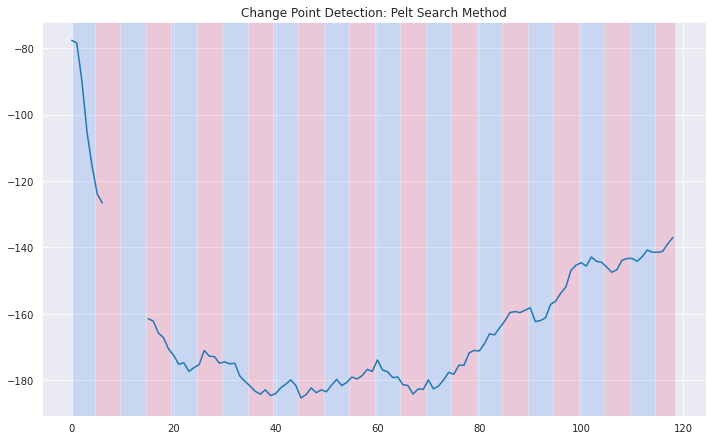

In [35]:
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=500)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  

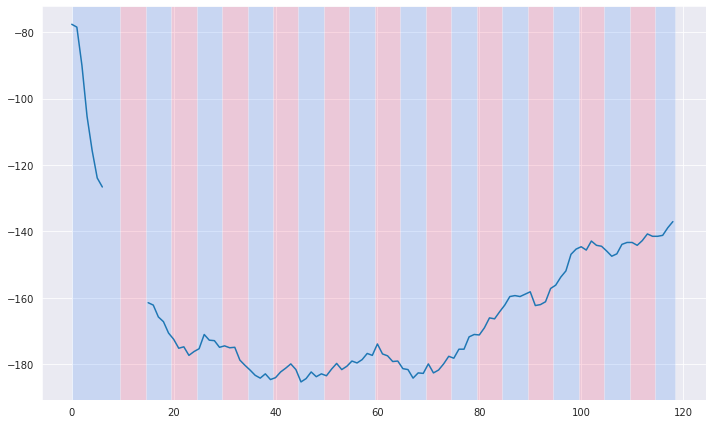

In [36]:
# change point detection
model = "l2"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(pen=500)

# show results
fig, (ax,) = rpt.display(points, my_bkps, figsize=(10, 6))
plt.show()

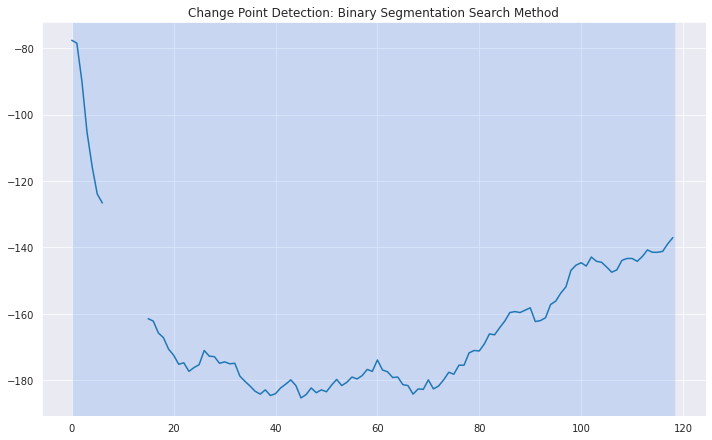

In [37]:
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(pen=100)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()

In [38]:
my_bkps

[119]

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning:

invalid value encountered in greater

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning:

invalid value encountered in greater



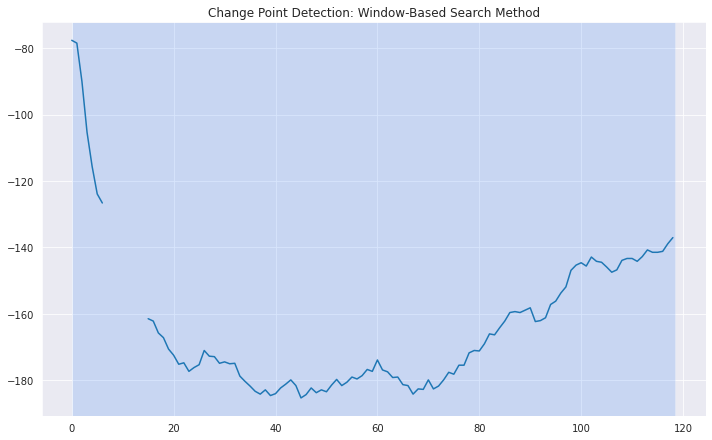

In [39]:
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=7, model=model).fit(points)
my_bkps = algo.predict(pen=500)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()

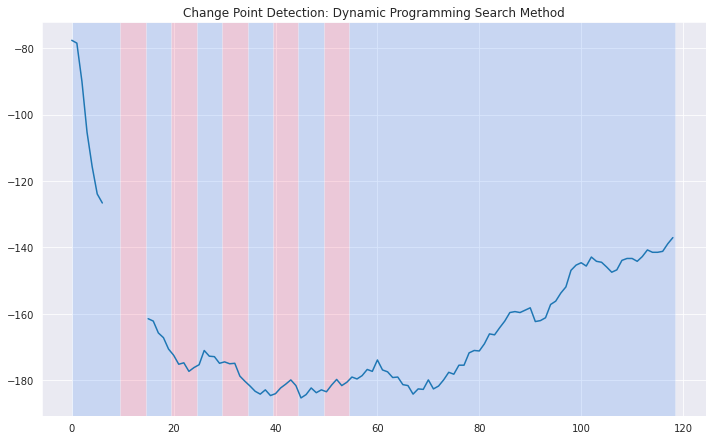

In [40]:
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

In [41]:
#df = rolling_rutas_8hr_panel_selected

def break_points_CDP (df, penalizacion):
    results = pd.DataFrame(columns = ['ruta', 'pelt_rbf', 'n_points_pelt_rbf', 'pelt_l2', 'n_points_pelt_l2', 'window_based', 'n_points_window_based'])
    results['ruta'] = df.columns.values
    
    for i,ruta in enumerate(results.ruta):
        points=np.array(df[ruta])
        #Changepoint detection with the Pelt method rbf
        model = "rbf"  
        algo = rpt.Pelt(model=model).fit(points)
        my_bkps = algo.predict(pen=penalizacion)
        #print(ruta, my_bkps)
        results.at[i,'pelt_rbf'] = my_bkps
    
        #Changepoint detection with the Pelt method rbf
        model = "l2"  
        algo = rpt.Pelt(model=model).fit(points)
        my_bkps = algo.predict(pen=penalizacion)
        #print(ruta, my_bkps)
        results.at[i,'pelt_l2'] = my_bkps
    
        #Changepoint detection with window-based search method
        model = "l2"  
        algo = rpt.Window(width=7, model=model).fit(points)
        my_bkps = algo.predict(pen=penalizacion)
        results.at[i,'window_based'] = my_bkps
        
    results['n_points_pelt_rbf'] = results['pelt_rbf'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    results['n_points_pelt_l2'] = results['pelt_l2'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    results['n_points_window_based'] = results['window_based'].apply(lambda x: len(x) if isinstance(x, list) else 0)
        
    return results

In [42]:
rolling_rutas_8hr_panel_selected.iloc[0:50, 10:20]

geometry    (-99.151611328125 19.404430166748085, -99.151611328125 19.383704304380334)  \
2020-03-17                                                NaN                            
2020-03-18                                                NaN                            
2020-03-19                                                NaN                            
2020-03-20                                                NaN                            
2020-03-21                                                NaN                            
2020-03-22                                                NaN                            
2020-03-23                                         -85.435714                            
2020-03-24                                         -91.578571                            
2020-03-25                                        -102.150000                            
2020-03-26                                        -109.864286                            
2020-03-27                                        -117.292857                            
2020-03-28                                        -122.007143                            
2020-03-29                                        -128.292857                            
2020-03-30                                                NaN                            
2020-03-31                                                NaN                            
2020-04-01                                                NaN                            
2020-04-02                                                NaN                            
2020-04-03                                                NaN                            
2020-04-04                                                NaN                            
2020-04-05                                                NaN                            
2020-04-06                                                NaN                            
2020-04-07                                        -155.721429                            
2020-04-08                                        -153.578571                            
2020-04-09                                        -154.864286                            
2020-04-10                                        -155.578571                            
2020-04-11                                        -154.435714                            
2020-04-12                                        -157.435714                            
2020-04-13                                        -157.150000                            
2020-04-14                                        -157.435714                            
2020-04-15                                        -158.864286                            
2020-04-16                                        -157.292857                            
2020-04-17                                        -155.864286                            
2020-04-18                                        -156.864286                            
2020-04-19                                        -154.578571                            
2020-04-20                                        -153.292857                            
2020-04-21                                        -153.435714                            
2020-04-22                                        -153.150000                            
2020-04-23                                        -153.435714                            
2020-04-24                                        -151.864286                            
2020-04-25                                        -151.435714                            
2020-04-26                                        -154.435714                            
2020-04-27                                        -155.150000                            
2020-04-28                                        -156.007143                            
2020-04-29                              

In [43]:
cpd = break_points_CDP(rolling_rutas_8hr_panel_selected.loc['2020-04-07':,:], 500) #['2020-03-23':, :], 500)
cpd

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning:

invalid value encountered in greater

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning:

invalid value encountered in greater



ruta  \
0   (-98.887939453125 19.508019823370297, -98.8879...   
1   (-99.12963867187499 19.42515338859868, -99.151...   
2   (-99.12963867187501 19.300774497281314, -99.12...   
3   (-99.12963867187501 19.487307187313725, -99.12...   
4   (-99.15161132812499 19.42515338859868, -99.129...   
5   (-99.15161132812499 19.42515338859868, -99.151...   
6   (-99.15161132812499 19.42515338859868, -99.173...   
7   (-99.15161132812499 19.42515338859868, -99.173...   
8   (-99.151611328125 19.383704304380334, -99.1735...   
9   (-99.151611328125 19.404430166748085, -99.1516...   
10  (-99.151611328125 19.404430166748085, -99.1516...   
11  (-99.151611328125 19.4458739675579, -99.151611...   
12  (-99.151611328125 19.4458739675579, -99.173583...   
13  (-99.151611328125 19.508019823370297, -99.1296...   
14  (-99.17358398437499 19.383704304380334, -99.17...   
15  (-99.17358398437499 19.383704304380334, -99.17...   
16  (-99.17358398437499 19.383704304380334, -99.17...   
17  (-99.17358398437499 19.404430166748085, -99.15...   
18  (-99.17358398437499 19.404430166748085, -99.17...   
19  (-99.17358398437499 19.404430166748085, -99.17...   
20  (-99.173583984375 19.362975803871336, -99.1735...   
21  (-99.173583984375 19.362975803871336, -99.1955...   
22  (-99.173583984375 19.42515338859868, -99.12963...   
23  (-99.173583984375 19.42515338859868, -99.15161...   
24  (-99.173583984375 19.42515338859868, -99.15161...   
25  (-99.173583984375 19.42515338859868, -99.17358...   
26  (-99.173583984375 19.42515338859868, -99.17358...   
27  (-99.173583984375 19.42515338859868, -99.19555...   
28  (-99.173583984375 19.4458739675579, -99.151611...   
29  (-99.173583984375 19.4458739675579, -99.173583...   
30  (-99.19555664062499 19.42515338859868, -99.173...   
31  (-99.19555664062499 19.42515338859868, -99.195...   
32  (-99.195556640625 19.4458739675579, -99.173583...   
33  (-99.28344726562501 19.362975803871336, -99.26...   

                                             pelt_rbf  n_points_pelt_rbf  \
0   [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
1                                               [104]                  1   
2                                               [104]                  1   
3                                               [104]                  1   
4                                               [104]                  1   
5                                               [104]                  1   
6                                               [104]                  1   
7                                               [104]                  1   
8                                               [104]                  1   
9                                               [104]                  1   
10                                              [104]                  1   
11                                              [104]                  1   
12                                              [104]                  1   
13  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
14                                              [104]                  1   
15                                              [104]                  1   
16  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
17                                              [104]                  1   
18                                              [104]                  1   
19                                              [104]                  1   
20  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
21  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
22  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
23                                              [104]                  1   
24                                              [104]                  1   
25                                              [104]                  1   
2

### CDP para todas las rutas 08 hrs

In [44]:
rutas_8hr_panel = rutas_8hr.groupby(['geometry', 'fecha']).mean()['n_difference'].unstack().transpose()
rutas_8hr_panel = rutas_8hr_panel.reindex(dias_serie)
print(rutas_8hr_panel.shape)
rutas_8hr_panel.head(30)

(125, 14849)


geometry    (-98.75610351562499 19.508019823370297, -98.887939453125 19.508019823370297)  \
2020-03-17                                                7.0                              
2020-03-18                                               -1.0                              
2020-03-19                                               -2.4                              
2020-03-20                                                1.4                              
2020-03-21                                                NaN                              
2020-03-22                                                NaN                              
2020-03-23                                               -0.8                              
2020-03-24                                               -3.0                              
2020-03-25                                                NaN                              
2020-03-26                                               -0.4                              
2020-03-27                                                NaN                              
2020-03-28                                                NaN                              
2020-03-29                                                NaN                              
2020-03-30                                                NaN                              
2020-03-31                                                NaN                              
2020-04-01                                               -6.0                              
2020-04-02                                               -4.4                              
2020-04-03                                                NaN                              
2020-04-04                                                1.0                              
2020-04-05                                                NaN                              
2020-04-06                                                NaN                              
2020-04-07                                                NaN                              
2020-04-08                                               -2.0                              
2020-04-09                                               -2.4                              
2020-04-10                                                NaN                              
2020-04-11                                                0.0                              
2020-04-12                                                NaN                              
2020-04-13                                                NaN                              
2020-04-14                                               -4.0                              
2020-04-15                                                NaN                              

geometry    (-98.75610351562499 19.54943713600337, -98.887939453125 19.508019823370297)  \
2020-03-17                                                NaN                             
2020-03-18                                                NaN                             
2020-03-19                                                NaN                             
2020-03-20                                                NaN                             
2020-03-21                                                NaN                             
2020-03-22                                                NaN                             
2020-03-23                                                NaN                             
2020-03-24                                                NaN                             
2020-03-25                                                NaN                             
2020-03-26                                                NaN                             
2020-03-27                                                NaN                             
2020-03-28                                             

In [45]:
## rolling average
rolling_rutas_8hr_panel_all = rutas_8hr_panel.rolling(7).mean()
print(rolling_rutas_8hr_panel_all.shape)
rolling_rutas_8hr_panel_all.head(10)

(125, 14849)


geometry    (-98.75610351562499 19.508019823370297, -98.887939453125 19.508019823370297)  \
2020-03-17                                                NaN                              
2020-03-18                                                NaN                              
2020-03-19                                                NaN                              
2020-03-20                                                NaN                              
2020-03-21                                                NaN                              
2020-03-22                                                NaN                              
2020-03-23                                                NaN                              
2020-03-24                                                NaN                              
2020-03-25                                                NaN                              
2020-03-26                                                NaN                              

geometry    (-98.75610351562499 19.54943713600337, -98.887939453125 19.508019823370297)  \
2020-03-17                                                NaN                             
2020-03-18                                                NaN                             
2020-03-19                                                NaN                             
2020-03-20                                                NaN                             
2020-03-21                                                NaN                             
2020-03-22                                                NaN                             
2020-03-23                                                NaN                             
2020-03-24                                                NaN                             
2020-03-25                                                NaN                             
2020-03-26                                                NaN                             

geometry    (-98.756103515625 19.21780263228372, -98.75610351562499 19.197053112379514)  \
2020-03-17                                                NaN                             
2020-03-18                                                NaN                             
2020-03-19                                                NaN                             
2020-03-20                                                NaN                             
2020-03-21                                                NaN                             
2020-03-22                                                NaN                             
2020-03-23                                                NaN                             
2020-03-24                                                NaN                             
2020-03-25                                                NaN                             
2020-03-26                                                NaN                             

geometry    (-98.756103515625 19.21780263228372, -98.77807617187501 19.197053112379514)  \
2020-03-17                                                NaN                             
2020-03-18                                                NaN                             
2020-03-19                                                NaN                             
2020-03-20                                                NaN                             
2020-03-21                                                NaN                             
2020-03-22                                                NaN                             
2020-03-23                                                NaN                             
2020-03-24                                                NaN                             
2020-03-25                                          -1.535714                             
2020-03-26                                          -1.678571            

In [46]:
cpd = break_points_CDP(rolling_rutas_8hr_panel_all.loc['2020-04-07':,:], 500)
cpd

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning:

invalid value encountered in greater

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning:

invalid value encountered in greater



ruta  \
0      (-98.75610351562499 19.508019823370297, -98.88...   
1      (-98.75610351562499 19.54943713600337, -98.887...   
2      (-98.756103515625 19.21780263228372, -98.75610...   
3      (-98.756103515625 19.21780263228372, -98.77807...   
4      (-98.756103515625 19.21780263228372, -98.80004...   
...                                                  ...   
14844  (-99.371337890625 19.69431390762537, -99.34936...   
14845  (-99.37133789062501 19.342244667598706, -99.34...   
14846  (-99.37133789062501 19.362975803871336, -99.34...   
14847  (-99.393310546875 19.300774497281314, -99.3713...   
14848  (-99.393310546875 19.652933877000336, -99.3713...   

                                                pelt_rbf  n_points_pelt_rbf  \
0      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
1      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
2      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
3      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
4      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
...                                                  ...                ...   
14844  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
14845  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
14846                                              [104]                  1   
14847  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
14848  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   

                                                 pelt_l2  n_points_pelt_l2  \
0      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
1      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
2      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
3      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
4      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
...                                                  ...               ...   
14844  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
14845  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
14846                                              [104]                 1   
14847  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
14848  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   

      window_based  n_points_window_based  
0            [104]                      1  
1            [104]                      1  
2            [104]                      1  
3            [104]                      1  
4            [104]                      1  
...            ...                    ...  
14844        [104]                      1  
14845        [104]                      1  
14846        [104]                      1  
14847        [104]                      1  
14848        [104]                      1  

[14849 rows x 7 columns]

In [47]:
cpd.groupby('n_points_pelt_rbf').size()

n_points_pelt_rbf
1      1747
21    13102
dtype: int64

In [48]:
cpd.groupby('n_points_pelt_l2').size()

n_points_pelt_l2
1       506
2       835
3       294
4        89
5        33
6        11
7         6
8        12
9         8
10        9
11       22
12       28
13       29
14       12
15       56
16       51
17       37
18       97
19       81
20      203
21    12430
dtype: int64

In [49]:
cpd.groupby('n_points_window_based').size()

n_points_window_based
1    14220
2      332
3      151
4       83
5       36
6       18
7        5
8        4
dtype: int64

In [98]:
### Guardamos las rutas
index_selected = cpd[cpd['n_points_pelt_l2']==1]['ruta']
index_selected.to_csv("~/bj/data/rutas_tiles/rutas_8hr_cpd.csv")

### Rutas por tiles: 16 hrs

In [51]:
# Reshape
rutas_16hr_panel = rutas_16hr.groupby(['geometry', 'fecha']).mean()['percent_change'].unstack().transpose()
rutas_16hr_panel = rutas_16hr_panel.reindex(dias_serie)
rutas_16hr_panel = rutas_16hr_panel.transpose()

# Selecciono lo a ventana de tiempo
rutas_16hr_panel = rutas_16hr_panel.loc[:, fecha_ini:fecha_fin]
print(rutas_16hr_panel.shape)

rutas_16hr_panel_lag = rutas_16hr_panel.loc[:, fecha_ini:fecha_fin_lag]
rutas_16hr_panel_lag.columns = rutas_16hr_panel.columns[7:]
print(rutas_16hr_panel_lag.shape)
#rutas_16hr_panel_lag.head(3)

rutas_16hr_panel_diff = rutas_16hr_panel - rutas_16hr_panel_lag
rutas_16hr_panel_diff.drop(rutas_16hr_panel_diff.columns[:7], axis=1, inplace=True)
rutas_16hr_panel_diff.dropna(how='all', axis=0, inplace=True)
print(rutas_16hr_panel_diff.shape)
rutas_16hr_panel_diff.head(3)

(17039, 77)
(17039, 70)
(12015, 70)


2020-03-30  2020-03-31  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...         NaN         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-04-01  2020-04-02  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...  -31.914894  -26.666667   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-04-03  2020-04-04  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...  -39.325843         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-04-05  2020-04-06  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...         NaN         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-04-07  2020-04-08  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...         NaN         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    ...  2020-05-29  \
geometry                                            ...               
(-98.75610351562499 19.508019823370297, -98.887...  ...         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...  ...         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...  ...         NaN   

                                                    2020-05-30  2020-05-31  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...         NaN         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-06-01  2020-06-02  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...         NaN         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-06-03  2020-06-04  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...         NaN         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         NaN   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-06-05  2020-06-06  \
geometry                                                                     
(-98.75610351562499 19.508019823370297, -98.887...         NaN         NaN   
(-98.75610351562499 19.54943713600337, -98.8879...         NaN         0.0   
(-98.75610351562499 19.67362522793804, -98.7561...         NaN         NaN   

                                                    2020-06-07  
geometry                                                        
(-98.75610351562499 19.508019823370297, -98.887

In [52]:
stats = rutas_16hr_panel_diff.agg(['mean', 'max', 'min', 'std', 'count'], axis=1)
#stats.head(5)

In [53]:
stats_index = stats[(stats['mean']>=UMBRAL_CAMBIO_PORCENTUAL) & (stats['mean']<=-UMBRAL_CAMBIO_PORCENTUAL) &
      (stats['std']<= STD)  & (stats['max']<=-UMBRAL_CAMBIO_PORCENTUAL*2) & (stats['min']>=UMBRAL_CAMBIO_PORCENTUAL*2)].index
      #(stats['count']>=40)

# Obtenemos la base cuyo promedio es mayor al threshold
grupo16 = rutas_16hr_panel_diff.loc[stats_index]
#grupo16

In [54]:
grupo_16h =  rutas_con_reduccion_menor_al_thr(grupo16, UMBRAL_CAMBIO_PORCENTUAL)
print('Número de rutas con reducciones menores al {}% y mayores al {}: {:0,.0f}'.format(-UMBRAL_CAMBIO_PORCENTUAL, UMBRAL_CAMBIO_PORCENTUAL, grupo_8h.shape[0]))


Número de rutas con reducciones menores al 10% y mayores al -10: 539


In [55]:
grupos_grafica, subinterval = bins_para_graficar(grupo_16h, UMBRAL_CAMBIO_PORCENTUAL, STEP)

for i in range(0, len(grupos_grafica)):
    print("En el intervalo {} hay {:0,.0f} rutas".format(subinterval[i], grupos_grafica[i].shape[0]) )

En el intervalo (-10, -8] hay 14 rutas
En el intervalo (-8, -6] hay 26 rutas
En el intervalo (-6, -4] hay 38 rutas
En el intervalo (-4, -2] hay 87 rutas
En el intervalo (-2, 0] hay 196 rutas
En el intervalo (0, 2] hay 68 rutas
En el intervalo (2, 4] hay 62 rutas
En el intervalo (4, 6] hay 16 rutas
En el intervalo (6, 8] hay 12 rutas
En el intervalo (8, 10] hay 9 rutas


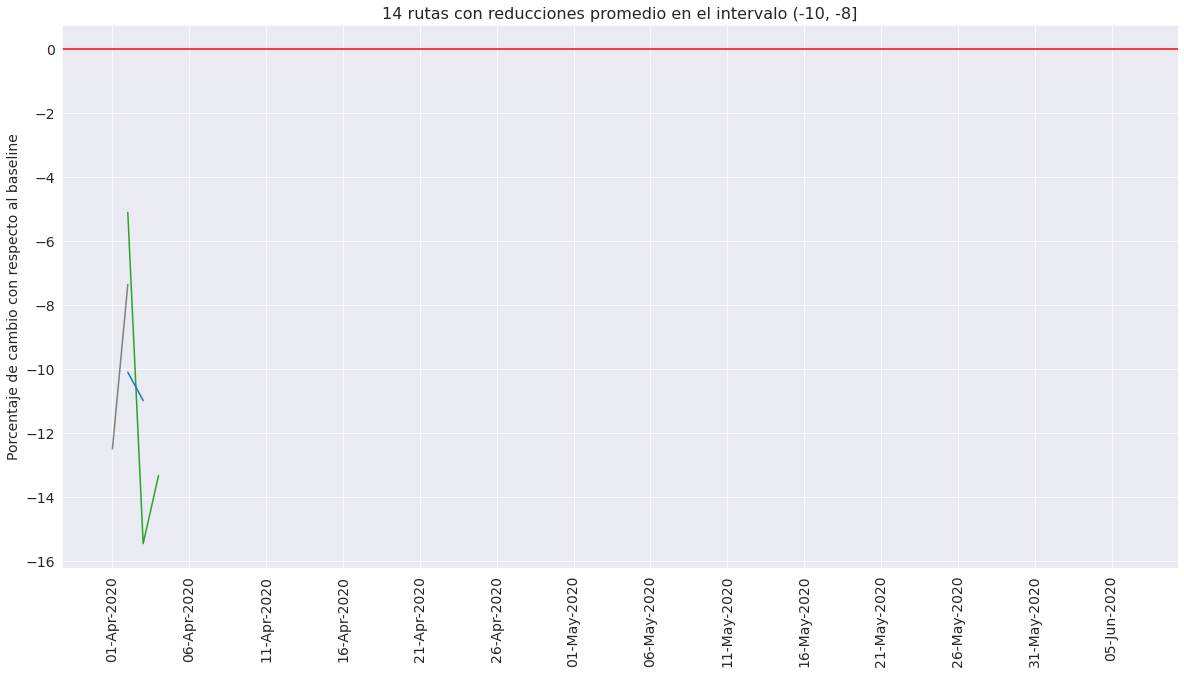

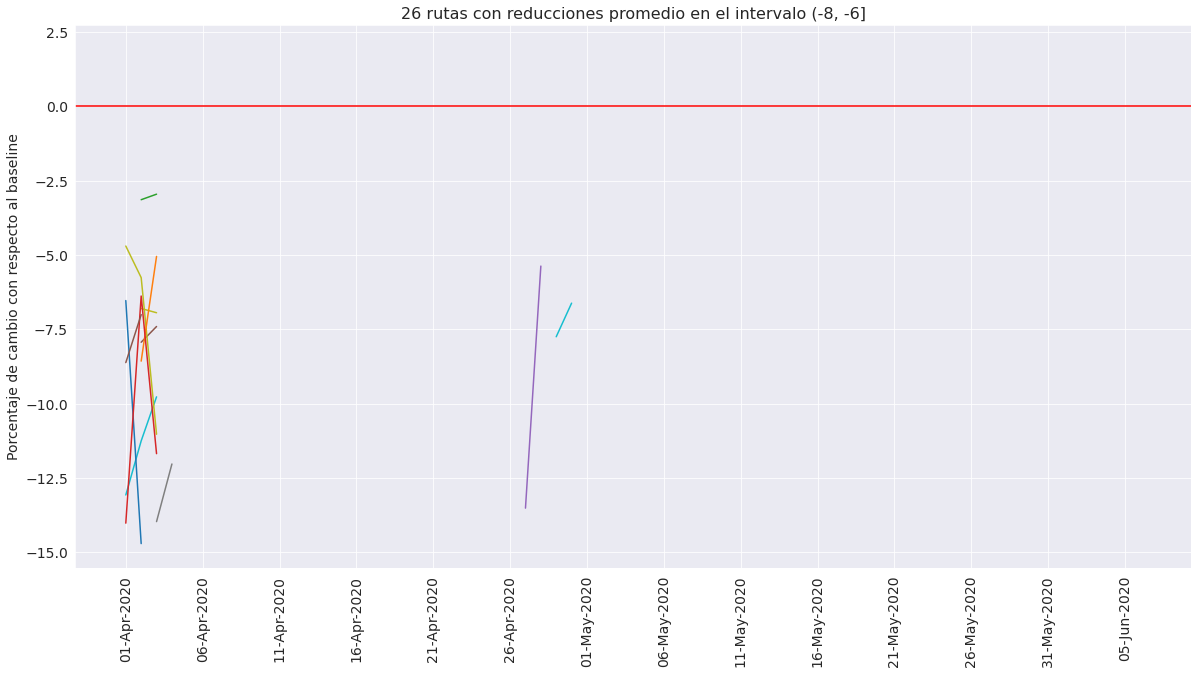

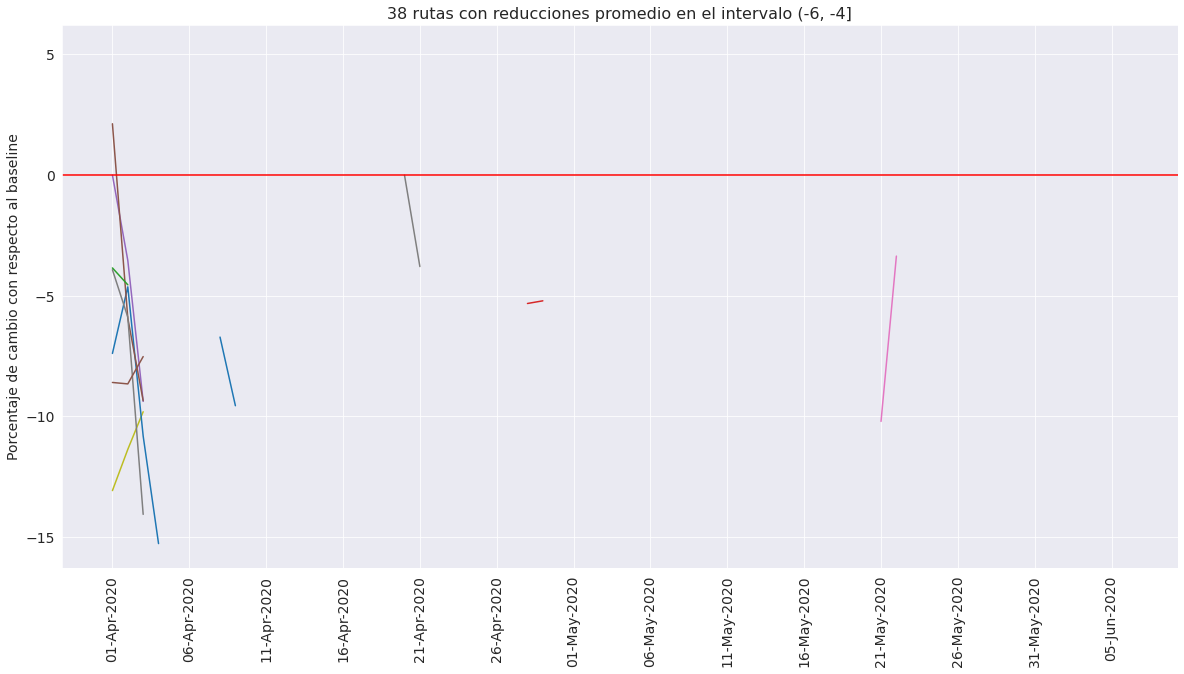

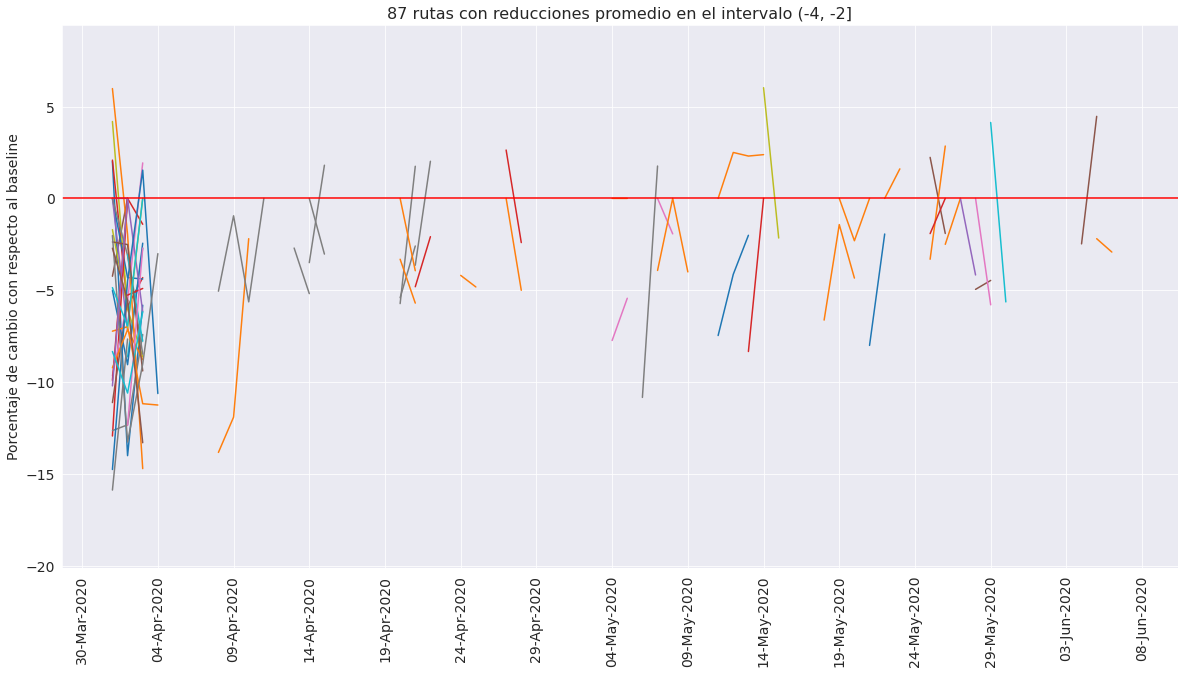

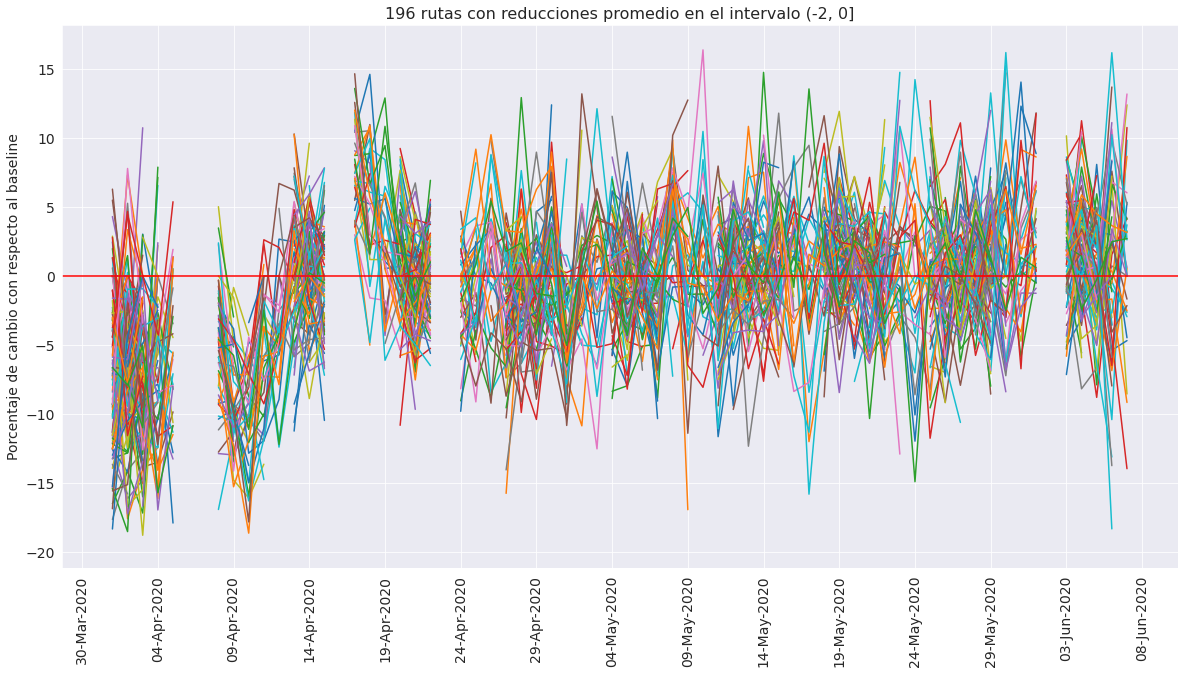

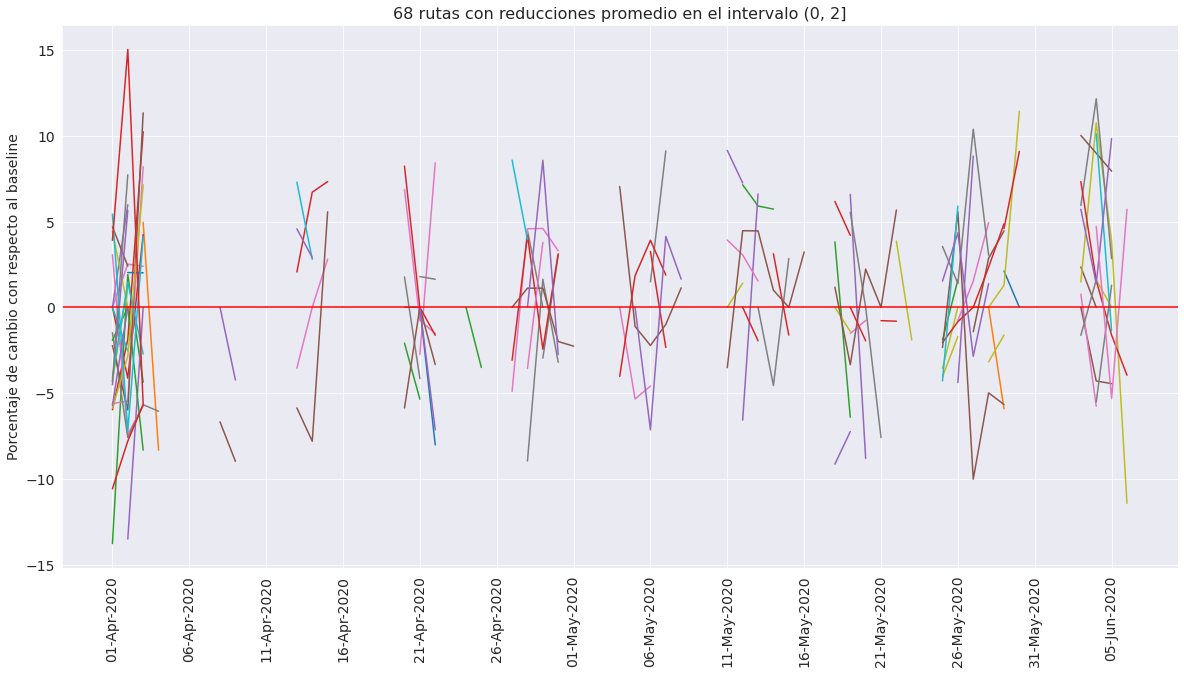

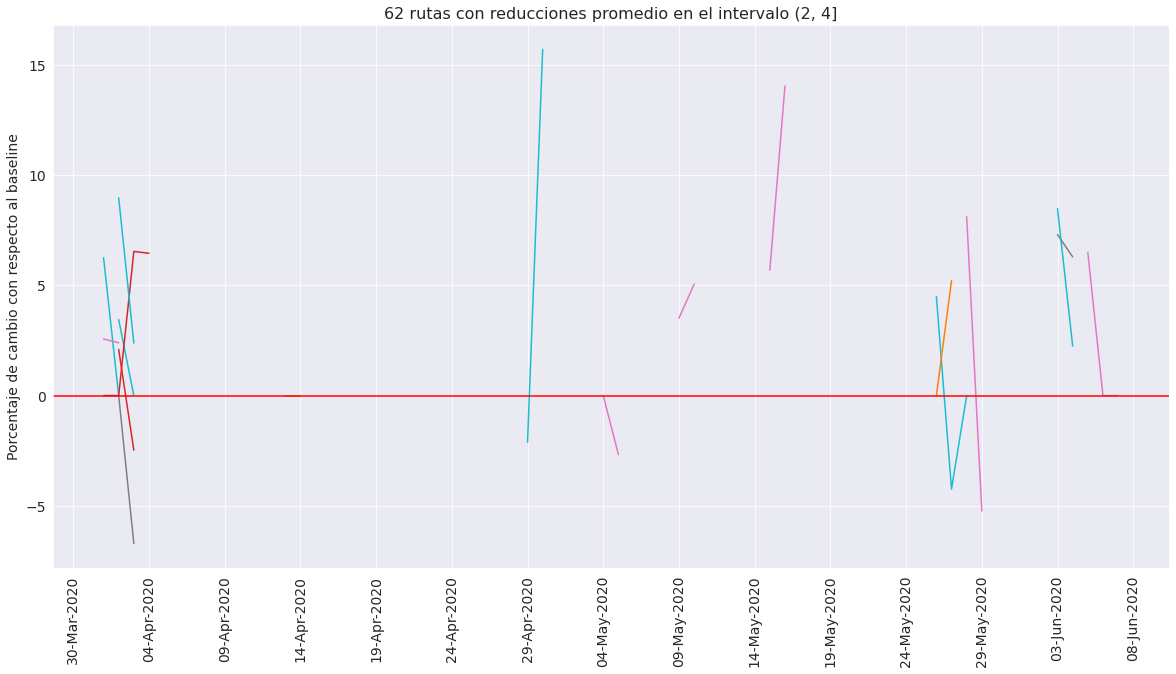

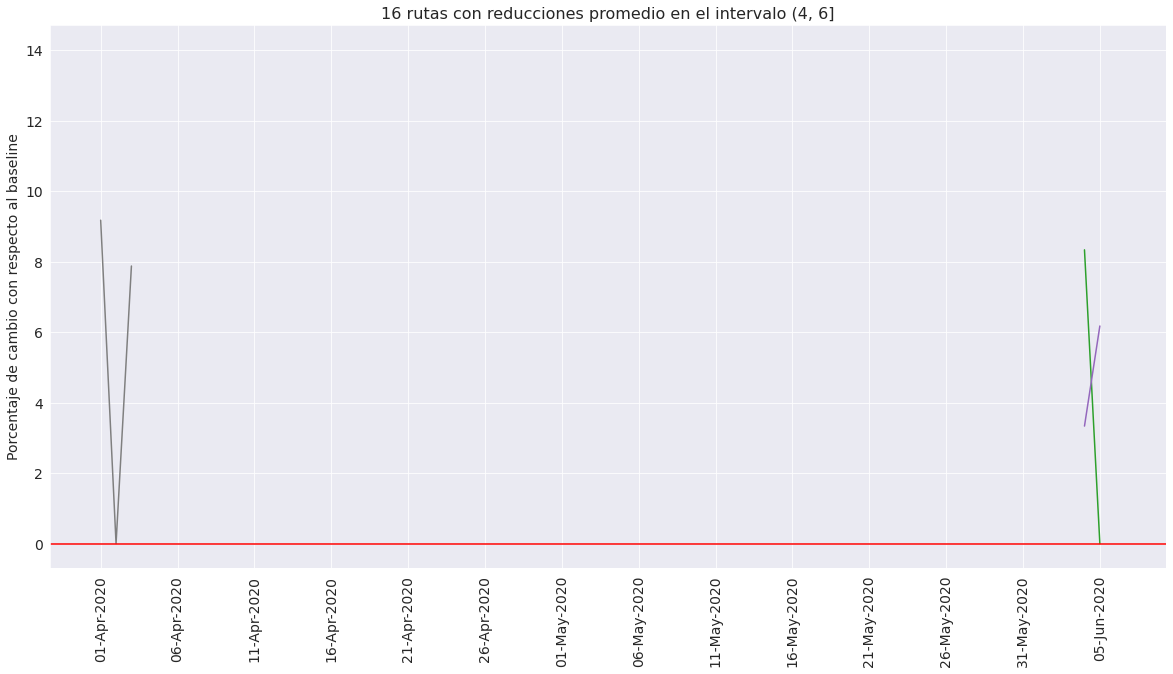

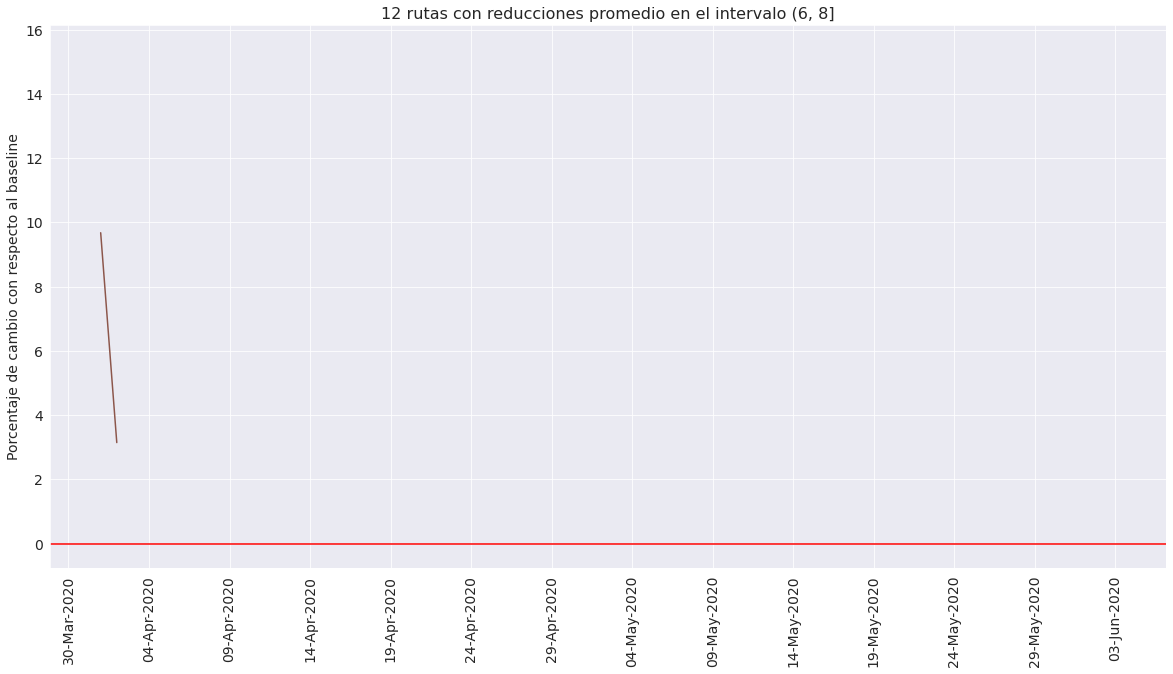

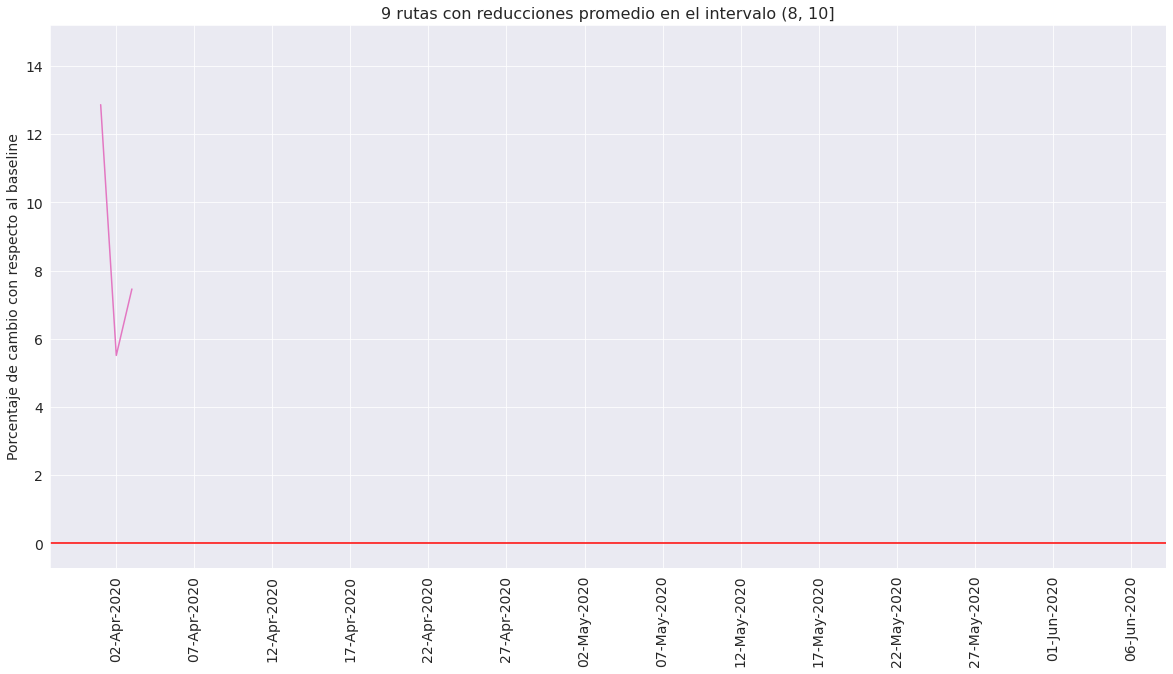

In [56]:
for i in range(0,len(grupos_grafica)):
    rutas = grupos_grafica[i].index 
    sub = [str(rutas.shape[0]), str(subinterval[i])]
    #grafica_cambio_en_en_tiempo_grupos(grupos_grafica[i], rutas, sub)
    grafica_cambio_en_en_tiempo_grupos_estatica(grupos_grafica[i], rutas, sub)

In [57]:
df_selected_16hr = grupos_grafica[4]
df_selected_16hr = df_selected_16hr[df_selected_16hr.isnull().sum(axis=1)<=20]
df_selected_16hr.to_csv("~/bj/data/rutas_tiles/rutas_16hr.csv")
df_selected_16hr

2020-03-30  2020-03-31  \
(-99.06372070312499 19.404430166748085, -99.173...         NaN         NaN   
(-99.129638671875 19.508019823370297, -99.12963...         NaN         NaN   
(-99.15161132812499 19.362975803871336, -99.173...         NaN         NaN   
(-99.15161132812499 19.362975803871336, -99.173...         NaN         NaN   
(-99.15161132812499 19.362975803871336, -99.173...         NaN         NaN   
(-99.15161132812499 19.42515338859868, -99.0856...         NaN         NaN   
(-99.15161132812499 19.42515338859868, -99.1296...         NaN         NaN   
(-99.15161132812499 19.42515338859868, -99.1735...         NaN         NaN   
(-99.15161132812499 19.42515338859868, -99.1735...         NaN         NaN   
(-99.151611328125 19.342244667598706, -99.17358...         NaN         NaN   
(-99.151611328125 19.383704304380334, -99.17358...         NaN         NaN   
(-99.151611328125 19.4458739675579, -99.1735839...         NaN         NaN   
(-99.17358398437499 19.383704304380334, -99.173...         NaN         NaN   
(-99.17358398437499 19.383704304380334, -99.173...         NaN         NaN   
(-99.17358398437499 19.383704304380334, -99.173...         NaN         NaN   
(-99.17358398437499 19.404430166748085, -99.151...         NaN         NaN   
(-99.17358398437499 19.404430166748085, -99.173...         NaN         NaN   
(-99.17358398437499 19.404430166748085, -99.173...         NaN         NaN   
(-99.17358398437499 19.404430166748085, -99.173...         NaN         NaN   
(-99.173583984375 19.362975803871336, -99.17358...         NaN         NaN   
(-99.173583984375 19.42515338859868, -99.151611...         NaN         NaN   
(-99.173583984375 19.42515338859868, -99.173583...         NaN         NaN   
(-99.173583984375 19.42515338859868, -99.173583...         NaN         NaN   
(-99.173583984375 19.42515338859868, -99.195556...         NaN         NaN   
(-99.173583984375 19.42515338859868, -99.195556...         NaN         NaN   
(-99.173583984375 19.4458739675579, -99.1735839...         NaN         NaN   
(-99.17358398437501 19.342244667598706, -99.195...         NaN         NaN   
(-99.19555664062499 19.404430166748085, -99.173...         NaN         NaN   
(-99.19555664062499 19.42515338859868, -99.1735...         NaN         NaN   
(-99.195556640625 19.362975803871336, -99.17358...         NaN         NaN   
(-99.19555664062501 19.383704304380334, -99.173...         NaN         NaN   
(-99.19555664062501 19.466591901253203, -99.173...         NaN         NaN   
(-99.217529296875 19.4458739675579, -99.1955566...         NaN         NaN   
(-99.28344726562501 19.362975803871336, -99.261...         NaN         NaN   

                                                    2020-04-01  2020-04-02  \
(-99.06372070312499 19.404430166748085, -99.173...  -13.937282   -8.868243   
(-99.129638671875 19.508019823370297, -99.12963...   -7.516848    0.260688   
(-99.15161132812499 19.362975803871336, -99.173...  -17.638413  -14.074427   
(-99.15161132812499 19.362975803871336, -99.173...  -15.441960  -11.530398   
(-99.15161132812499 19.362975803871336, -99.173...   -7.530120   -1.536098   
(-99.15161132812499 19.42515338859868, -99.0856...   -4.392387   -3.333333   
(-99.15161132812499 19.42515338859868, -99.1296...  -12.508935  -16.123379   
(-99.15161132812499 19.42515338859868, -99.1735...  -11.192087   -1.256913   
(-99.15161132812499 19.42515338859868, -99.1735...   -8.848697   -7.801833   
(-99.151611328125 19.342244667598706, -99.17358...   -9.287926   -6.635441   
(-99.151611328125 19.383704304380334, -99.17358...  -16.499705  -14.125956   
(-99.151611328125 19.4458739675579, -99.1735839...  -12.548263  -14.204545   
(-99.17358398437499 19.383704304380334, -99.173...  -11.265165  -10.814464   
(-99.17358398437499 19.383704304380334, -99.173...   -2.281211   -7.405925   
(-99.17358398437499 19.383704304380334, -99.173...  -12.500000   -6.605399   
(-99.17358398437499 19.404430166748085, -99.151...  -11.934361  -10.54746

In [58]:
rutas = df_selected_16hr.index 
sub = [str(rutas.shape[0]), str(subinterval[4])]
grafica_cambio_en_en_tiempo_grupos(df_selected_16hr, rutas, sub)
#grafica_cambio_en_en_tiempo_grupos_estatica(grupos_grafica[i], rutas, sub)

### CDP para rutas 16 hrs

In [59]:
rutas_16hr_panel = rutas_16hr.groupby(['geometry', 'fecha']).mean()['n_difference'].unstack().transpose()
rutas_16hr_panel = rutas_16hr_panel.reindex(dias_serie)
print(rutas_16hr_panel.shape)
rutas_16hr_panel.head(5)

(125, 17039)


geometry    (-98.75610351562499 19.197053112379514, -98.756103515625 19.21780263228372)  \
2020-03-17                                                NaN                             
2020-03-18                                                NaN                             
2020-03-19                                                NaN                             
2020-03-20                                                NaN                             
2020-03-21                                                NaN                             

geometry    (-98.75610351562499 19.197053112379514, -98.77807617187501 19.197053112379514)  \
2020-03-17                                                NaN                                
2020-03-18                                                NaN                                
2020-03-19                                                NaN                                
2020-03-20                                                NaN                                
2020-03-21                                                NaN                                

geometry    (-98.75610351562499 19.508019823370297, -98.887939453125 19.508019823370297)  \
2020-03-17                                                4.0                              
2020-03-18                                                NaN                              
2020-03-19                                               -2.0                              
2020-03-20                                                1.2                              
2020-03-21                                               -3.5                              

geometry    (-98.75610351562499 19.54943713600337, -98.887939453125 19.508019823370297)  \
2020-03-17                                                NaN                             
2020-03-18                                               7.00                             
2020-03-19                                               6.20                             
2020-03-20                                               2.20                             
2020-03-21                                               2.75                             

geometry    (-98.75610351562499 19.67362522793804, -98.75610351562501 19.69431390762537)  \
2020-03-17                                                NaN                              
2020-03-18                                                1.0                              
2020-03-19                                                NaN                              
2020-03-20                                               -3.6                              
2020-03-21                                                NaN                              

geometry    (-98.756103515625 19.21780263228372, -98.77807617187501 19.197053112379514)  \
2020-03-17                                                1.0                             
2020-03-18                                               -1.4                             
2020-03-19                                                5.4                             
2020-03-20                                                1.8                             
2020-03-21                                                0.0                             

geometry    (-98.756103515625 19.21780263228372, -98.800048828125 19.197053112379514)  \
2020-03-17                                              -6.60                           
2020-03-18                                               3.40                           
2020-03-19                                              -1.20                           
2020-03-20                                              -1.60                           
2020-03-21                                              -5.75                           

geometry    (-98.756103515625 19.21780263228372, -98.887939453125 19.259293812482564)  \
2020-03-17                                                4.4   

In [60]:
## rolling average
rolling_rutas_16hr_panel_all = rutas_16hr_panel.rolling(7).mean()
print(rolling_rutas_16hr_panel_all.shape)
cpd_16 = break_points_CDP(rolling_rutas_16hr_panel_all.loc['2020-04-07':,:], 500)
cpd_16

(125, 17039)


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning:

invalid value encountered in greater

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning:

invalid value encountered in greater



ruta  \
0      (-98.75610351562499 19.197053112379514, -98.75...   
1      (-98.75610351562499 19.197053112379514, -98.77...   
2      (-98.75610351562499 19.508019823370297, -98.88...   
3      (-98.75610351562499 19.54943713600337, -98.887...   
4      (-98.75610351562499 19.67362522793804, -98.756...   
...                                                  ...   
17034  (-99.39331054687499 19.238549533114522, -99.37...   
17035  (-99.39331054687499 19.238549533114522, -99.37...   
17036  (-99.393310546875 19.300774497281314, -99.3713...   
17037  (-99.393310546875 19.652933877000336, -99.3713...   
17038  (-99.39331054687501 19.508019823370297, -99.39...   

                                                pelt_rbf  n_points_pelt_rbf  \
0      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
1      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
2      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
3      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
4      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
...                                                  ...                ...   
17034  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
17035  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
17036  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
17037  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
17038  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   

                                                 pelt_l2  n_points_pelt_l2  \
0      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
1      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
2      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
3      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
4      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
...                                                  ...               ...   
17034  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
17035  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
17036  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
17037  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
17038  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   

      window_based  n_points_window_based  
0            [104]                      1  
1            [104]                      1  
2            [104]                      1  
3            [104]                      1  
4            [104]                      1  
...            ...                    ...  
17034        [104]                      1  
17035        [104]                      1  
17036        [104]                      1  
17037        [104]                      1  
17038        [104]                      1  

[17039 rows x 7 columns]

In [61]:
cpd_16.groupby('n_points_pelt_rbf').size()

n_points_pelt_rbf
21    17039
dtype: int64

In [62]:
cpd_16.groupby('n_points_pelt_l2').size()

n_points_pelt_l2
20     3360
21    13679
dtype: int64

In [63]:
cpd_16.groupby('n_points_window_based').size()

n_points_window_based
1    17039
dtype: int64

### Rutas por tiles: 00 hrs

In [64]:
# Reshape
rutas_0hr_panel = rutas_0hr.groupby(['geometry', 'fecha']).mean()['percent_change'].unstack().transpose()
rutas_0hr_panel = rutas_0hr_panel.reindex(dias_serie)
rutas_0hr_panel = rutas_0hr_panel.transpose()

# Selecciono lo a ventana de tiempo
rutas_0hr_panel = rutas_0hr_panel.loc[:, fecha_ini:fecha_fin]
print(rutas_0hr_panel.shape)

rutas_0hr_panel_lag = rutas_0hr_panel.loc[:, fecha_ini:fecha_fin_lag]
rutas_0hr_panel_lag.columns = rutas_0hr_panel.columns[7:]
print(rutas_0hr_panel_lag.shape)
#rutas_0hr_panel_lag.head(3)

rutas_0hr_panel_diff = rutas_0hr_panel - rutas_0hr_panel_lag
rutas_0hr_panel_diff.drop(rutas_0hr_panel_diff.columns[:7], axis=1, inplace=True)
rutas_0hr_panel_diff.dropna(how='all', axis=0, inplace=True)
print(rutas_0hr_panel_diff.shape)
rutas_0hr_panel_diff.head(3)

(20915, 77)
(20915, 70)
(15486, 70)


2020-03-30  2020-03-31  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...  -59.782609  -37.735849   
(-98.756103515625 19.21780263228372, -98.800048...         NaN  -16.666667   
(-98.756103515625 19.714999913710088, -98.75610...    8.928571   40.540541   

                                                    2020-04-01  2020-04-02  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...   35.714286    0.000000   
(-98.756103515625 19.21780263228372, -98.800048...         NaN         NaN   
(-98.756103515625 19.714999913710088, -98.75610...  -27.777778  -36.363636   

                                                    2020-04-03  2020-04-04  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...       -12.5   44.444444   
(-98.756103515625 19.21780263228372, -98.800048...         NaN         NaN   
(-98.756103515625 19.714999913710088, -98.75610...         0.0    7.547170   

                                                    2020-04-05  2020-04-06  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...  -14.598540   21.739130   
(-98.756103515625 19.21780263228372, -98.800048...   13.698630         NaN   
(-98.756103515625 19.714999913710088, -98.75610...   -9.433962   22.321429   

                                                    2020-04-07  2020-04-08  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...   18.867925    0.000000   
(-98.756103515625 19.21780263228372, -98.800048...         NaN         NaN   
(-98.756103515625 19.714999913710088, -98.75610...  -45.045045   15.873016   

                                                    ...  2020-05-29  \
geometry                                            ...               
(-98.756103515625 19.21780263228372, -98.778076...  ...         NaN   
(-98.756103515625 19.21780263228372, -98.800048...  ...         NaN   
(-98.756103515625 19.714999913710088, -98.75610...  ...    -4.62963   

                                                    2020-05-30  2020-05-31  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...         NaN   25.547445   
(-98.756103515625 19.21780263228372, -98.800048...         NaN         NaN   
(-98.756103515625 19.714999913710088, -98.75610...         0.0    0.000000   

                                                    2020-06-01  2020-06-02  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...   10.869565   23.584906   
(-98.756103515625 19.21780263228372, -98.800048...         NaN         NaN   
(-98.756103515625 19.714999913710088, -98.75610...  -17.857143   18.018018   

                                                    2020-06-03  2020-06-04  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...         NaN   24.691358   
(-98.756103515625 19.21780263228372, -98.800048...         NaN         NaN   
(-98.756103515625 19.714999913710088, -98.75610...   -3.968254   -4.545455   

                                                    2020-06-05  2020-06-06  \
geometry                                                                     
(-98.756103515625 19.21780263228372, -98.778076...         NaN         NaN   
(-98.756103515625 19.21780263228372, -98.800048...         NaN         NaN   
(-98.756103515625 19.714999913710088, -98.75610...   18.518519  -11.320755   

                                                    2020-06-07  
geometry                                                        
(-98.756103515625 19.21780263228372, -98.778076

In [65]:
stats = rutas_0hr_panel_diff.agg(['mean', 'max', 'min', 'std', 'count'], axis=1)
#stats.head(5)

In [66]:
stats_index = stats[(stats['mean']>=UMBRAL_CAMBIO_PORCENTUAL) & (stats['mean']<=-UMBRAL_CAMBIO_PORCENTUAL) &
      (stats['std']<= STD)  & (stats['max']<=-UMBRAL_CAMBIO_PORCENTUAL*2) & (stats['min']>=UMBRAL_CAMBIO_PORCENTUAL*2)].index
      #(stats['count']>=40)

# Obtenemos la base cuyo promedio es mayor al threshold
grupo0 = rutas_0hr_panel_diff.loc[stats_index]
#grupo16

In [67]:
grupo_0h =  rutas_con_reduccion_menor_al_thr(grupo0, UMBRAL_CAMBIO_PORCENTUAL)
print('Número de rutas con reducciones menores al {}% y mayores al {}: {:0,.0f}'.format(-UMBRAL_CAMBIO_PORCENTUAL, UMBRAL_CAMBIO_PORCENTUAL, grupo_8h.shape[0]))


Número de rutas con reducciones menores al 10% y mayores al -10: 539


In [68]:
grupos_grafica, subinterval = bins_para_graficar(grupo_0h, UMBRAL_CAMBIO_PORCENTUAL, STEP)

for i in range(0, len(grupos_grafica)):
    print("En el intervalo {} hay {:0,.0f} rutas".format(subinterval[i], grupos_grafica[i].shape[0]) )

En el intervalo (-10, -8] hay 31 rutas
En el intervalo (-8, -6] hay 31 rutas
En el intervalo (-6, -4] hay 66 rutas
En el intervalo (-4, -2] hay 122 rutas
En el intervalo (-2, 0] hay 208 rutas
En el intervalo (0, 2] hay 56 rutas
En el intervalo (2, 4] hay 65 rutas
En el intervalo (4, 6] hay 23 rutas
En el intervalo (6, 8] hay 13 rutas
En el intervalo (8, 10] hay 16 rutas


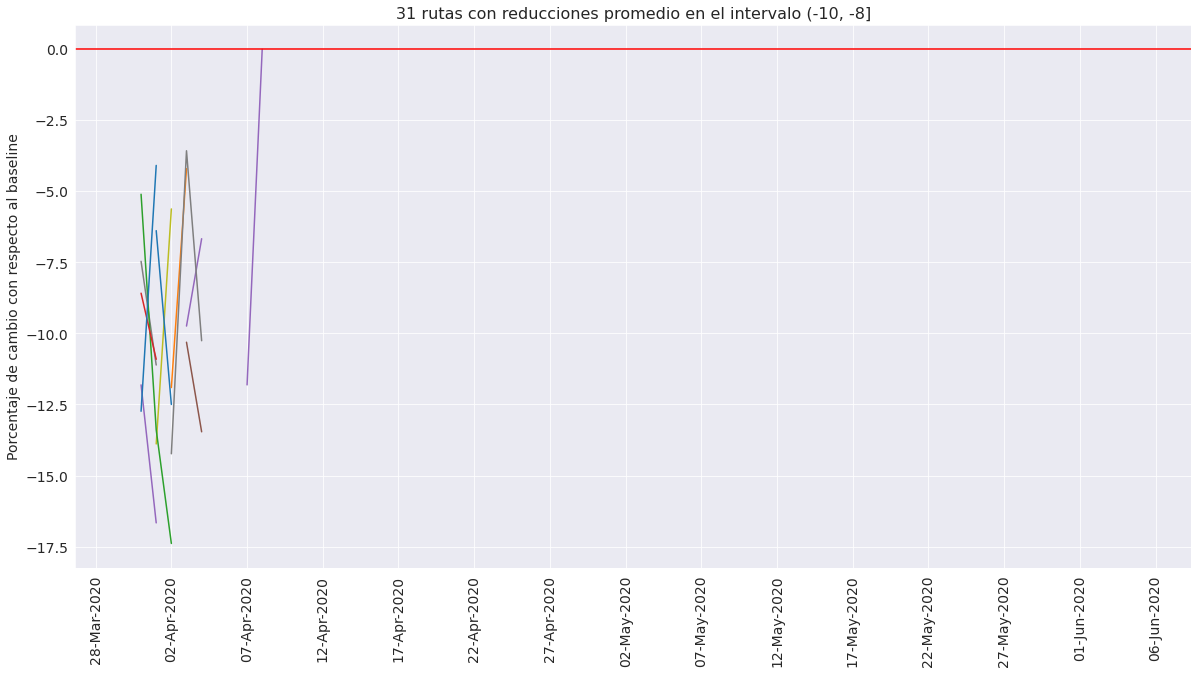

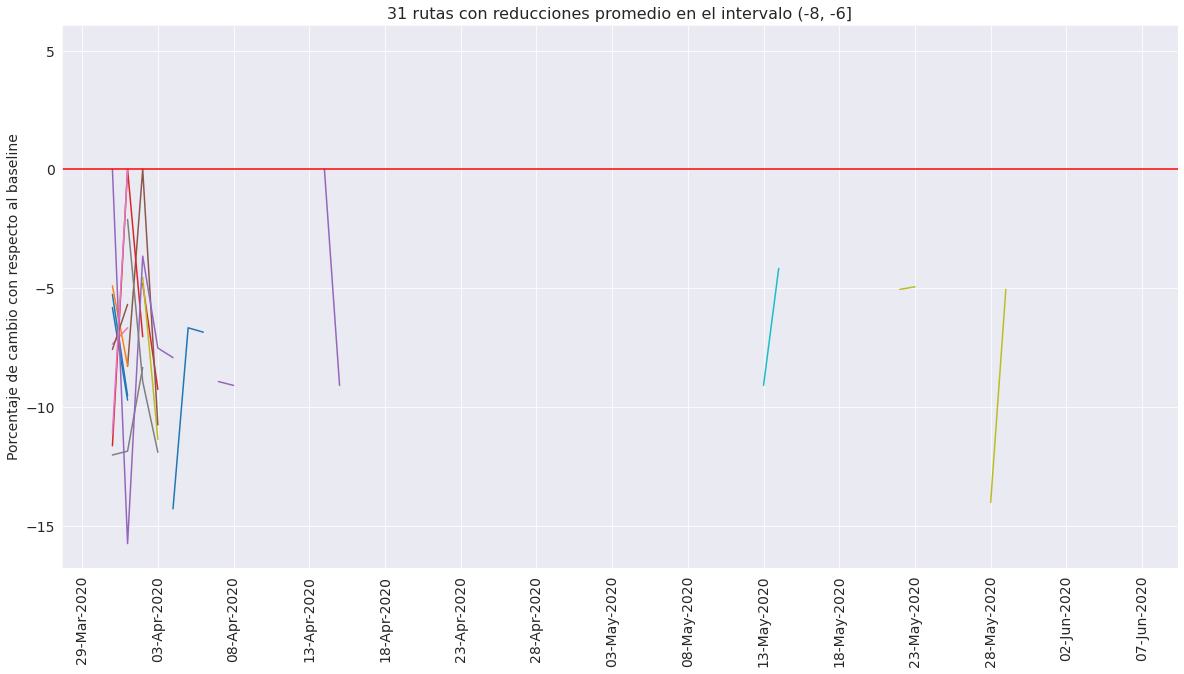

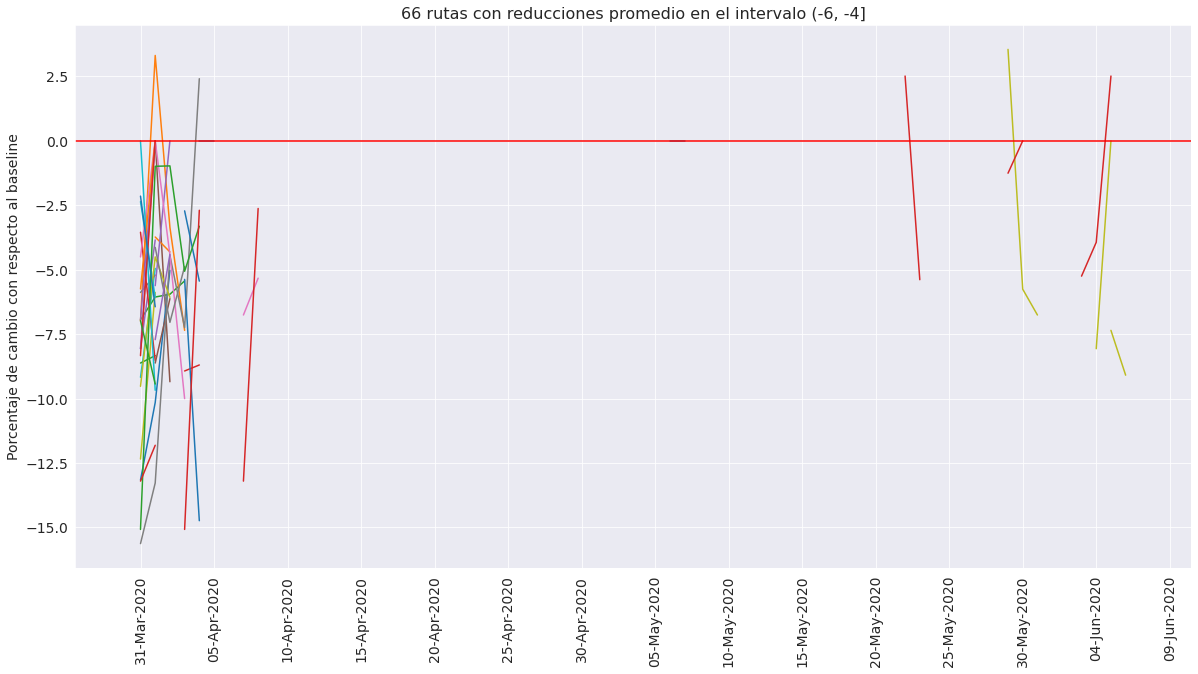

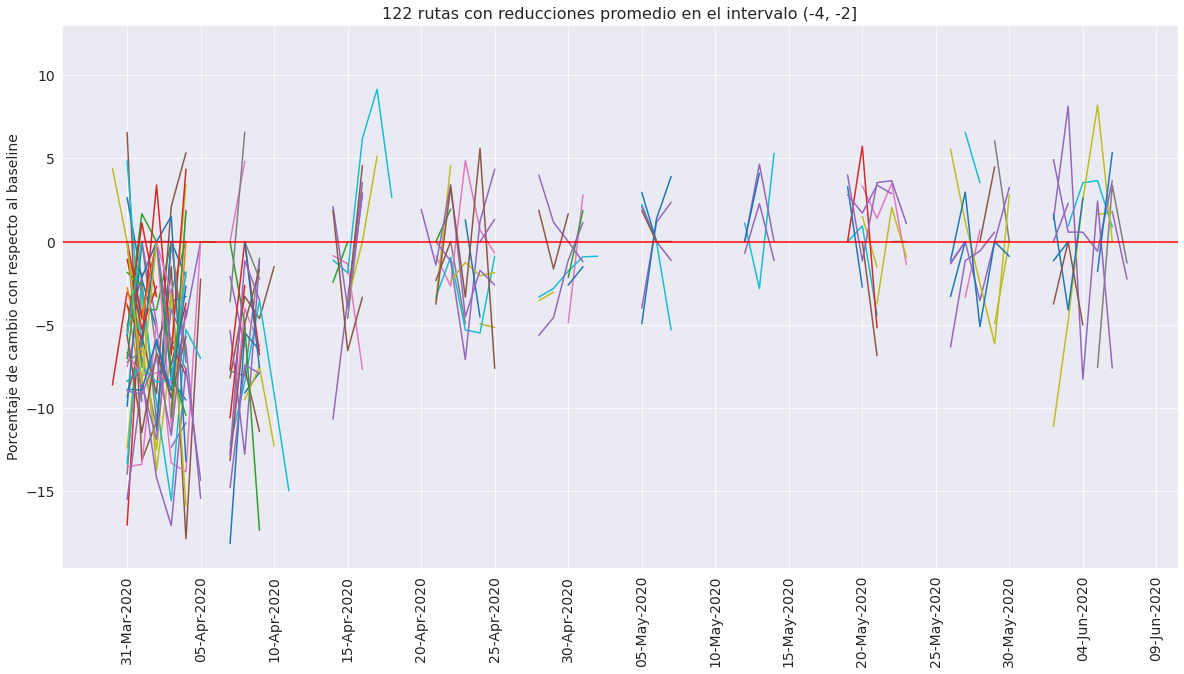

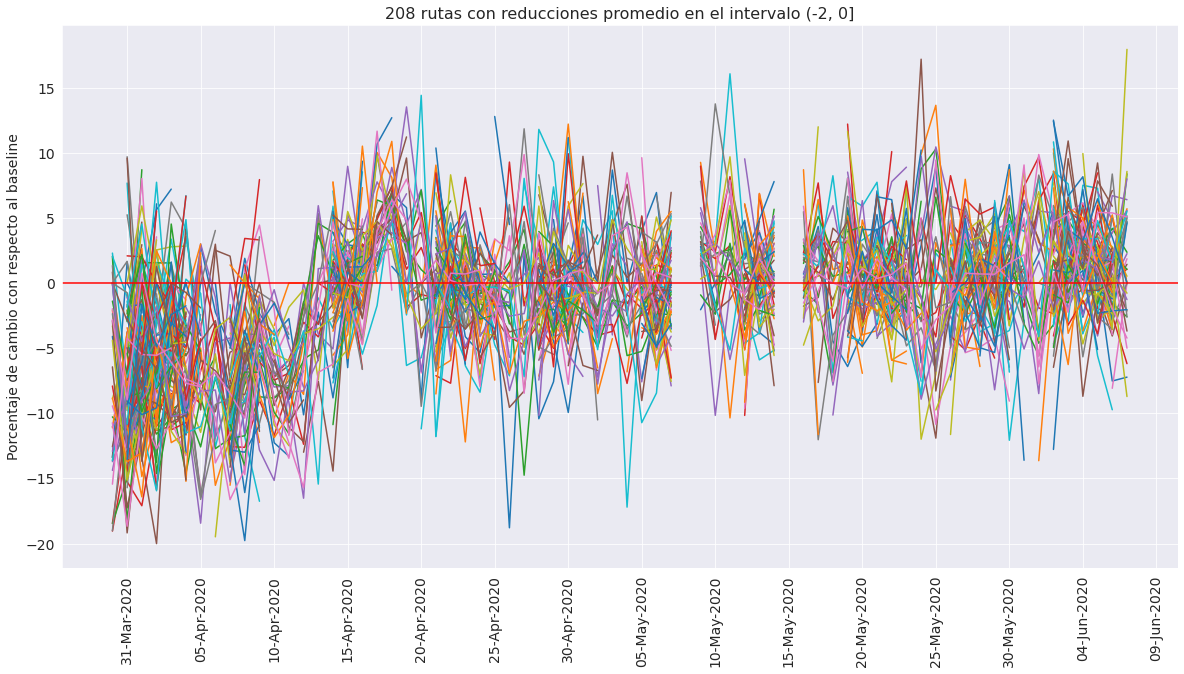

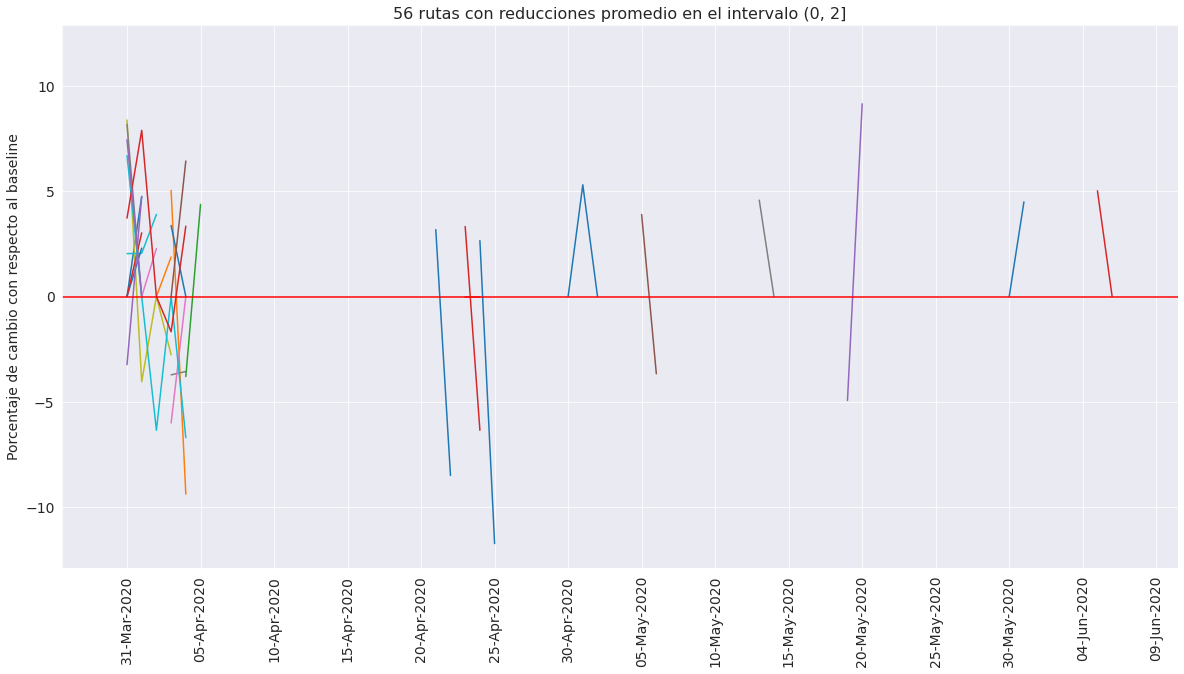

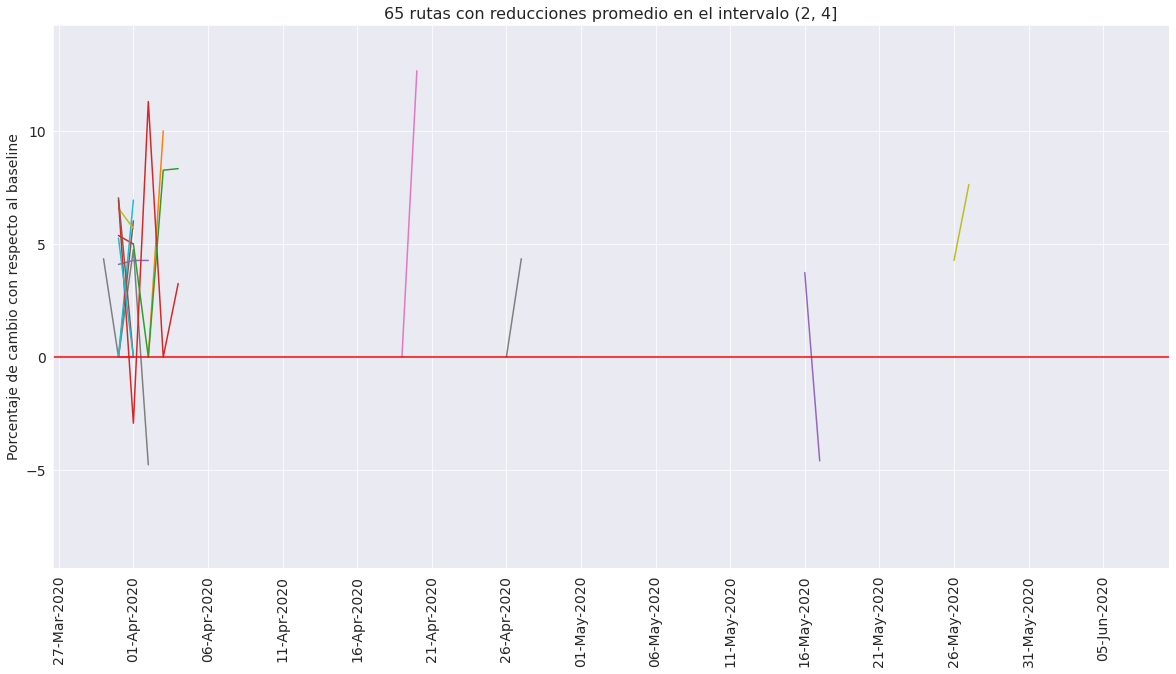

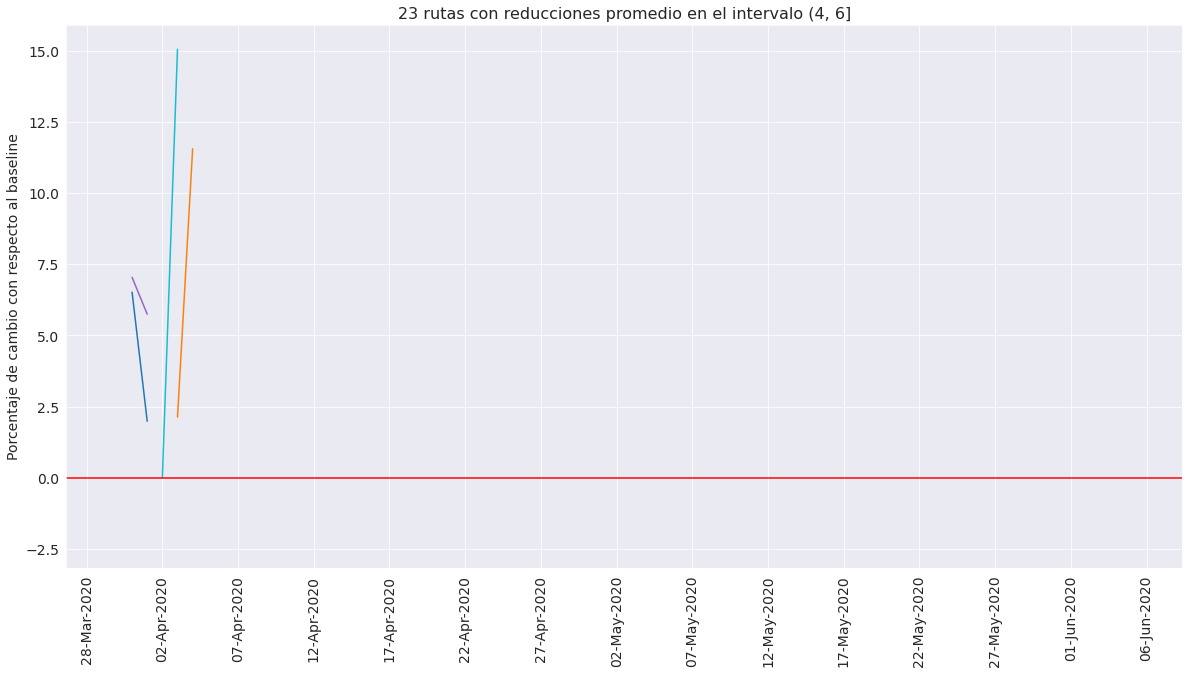

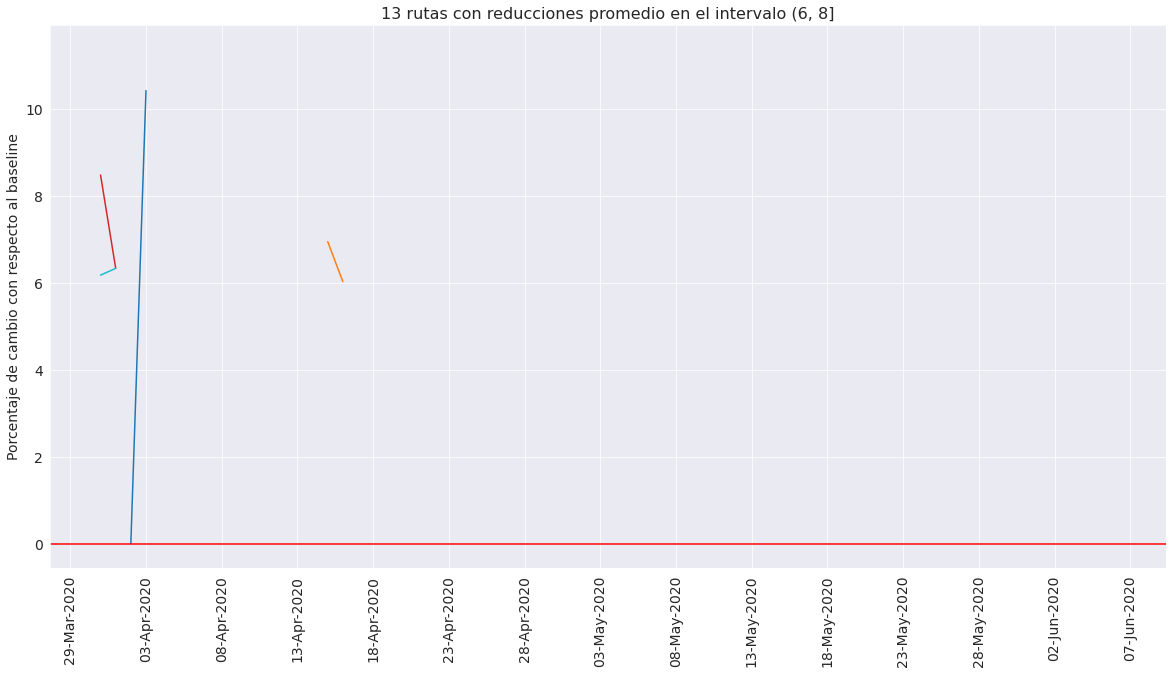

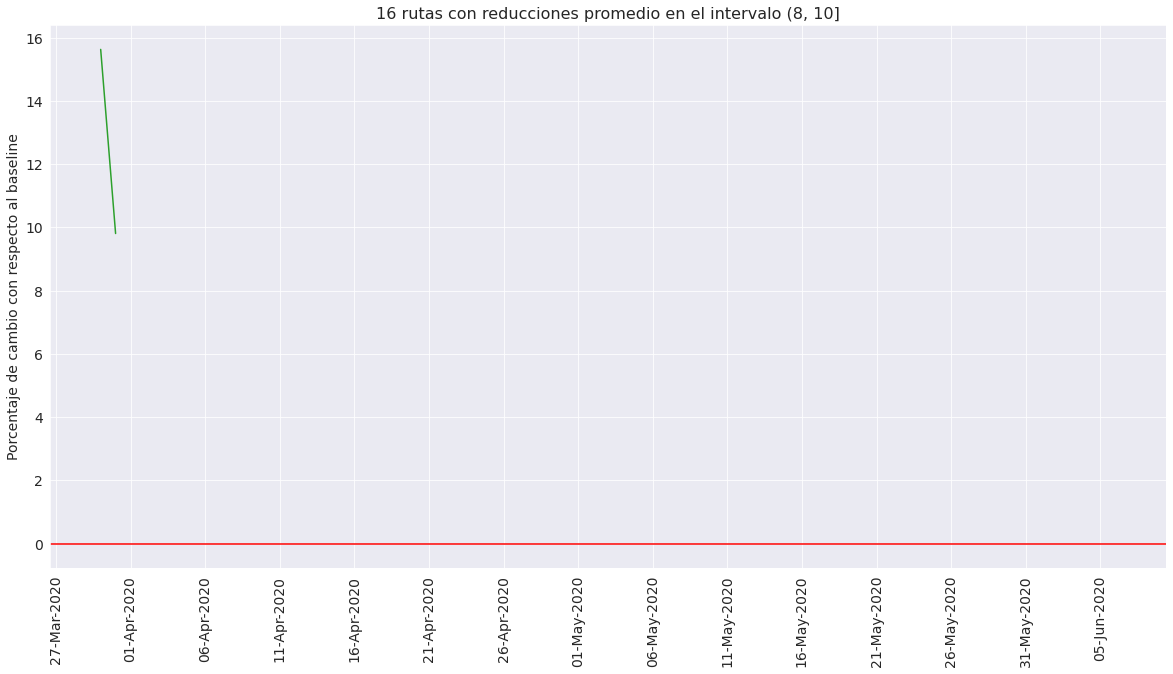

In [69]:
for i in range(0,len(grupos_grafica)):
    rutas = grupos_grafica[i].index 
    sub = [str(rutas.shape[0]), str(subinterval[i])]
    #grafica_cambio_en_en_tiempo_grupos(grupos_grafica[i], rutas, sub)
    grafica_cambio_en_en_tiempo_grupos_estatica(grupos_grafica[i], rutas, sub)

In [70]:
df_selected_0hr = grupos_grafica[4]
df_selected_0hr = df_selected_0hr[df_selected_0hr.isnull().sum(axis=1)<=20]
df_selected_0hr.to_csv("~/bj/data/rutas_tiles/rutas_0hr.csv")
df_selected_0hr

2020-03-30  2020-03-31  \
(-99.129638671875 19.508019823370297, -99.12963...    2.293578   -7.436570   
(-99.129638671875 19.508019823370297, -99.15161...  -13.392857    1.602564   
(-99.15161132812499 19.42515338859868, -99.1735...   -2.070393  -13.333333   
(-99.15161132812499 19.42515338859868, -99.1735...  -10.277492  -11.503478   
(-99.15161132812499 19.42515338859868, -99.1735...  -18.447837  -10.411737   
(-99.151611328125 19.280035468000158, -99.12963...  -12.562814   -7.216495   
(-99.17358398437499 19.383704304380334, -99.173...  -19.038985  -12.699713   
(-99.17358398437499 19.383704304380334, -99.173...  -13.707572  -10.955056   
(-99.17358398437499 19.383704304380334, -99.173...  -13.392857   -3.759398   
(-99.17358398437499 19.404430166748085, -99.151...  -13.609467  -11.145511   
(-99.17358398437499 19.404430166748085, -99.173...   -8.902077   -4.725340   
(-99.173583984375 19.362975803871336, -99.15161...    2.034588  -18.302829   
(-99.173583984375 19.362975803871336, -99.15161...   -7.908612  -14.509804   
(-99.173583984375 19.362975803871336, -99.17358...    0.841751  -12.722036   
(-99.173583984375 19.362975803871336, -99.17358...   -1.972387   -7.522124   
(-99.173583984375 19.42515338859868, -99.151611...  -18.457482  -14.984631   
(-99.173583984375 19.42515338859868, -99.173583...  -14.380531   -8.965929   
(-99.173583984375 19.42515338859868, -99.173583...   -6.437768  -17.261729   
(-99.173583984375 19.42515338859868, -99.173583...   -9.433962  -12.871287   
(-99.173583984375 19.42515338859868, -99.195556...   -2.358491  -11.653718   
(-99.173583984375 19.42515338859868, -99.195556...         NaN  -15.089163   
(-99.19555664062499 19.42515338859868, -99.1735...   -1.392758   -6.993007   
(-99.19555664062499 19.42515338859868, -99.1735...  -11.016949   -9.316770   
(-99.19555664062499 19.42515338859868, -99.2175...  -19.011407   -8.124077   
(-99.195556640625 19.4458739675579, -99.1516113...  -12.910798   -8.421053   
(-99.195556640625 19.4458739675579, -99.1516113...   -2.890173  -19.178082   
(-99.195556640625 19.4458739675579, -99.1735839...  -10.729614  -18.666667   
(-99.195556640625 19.4458739675579, -99.1735839...    1.333333  -12.367491   
(-99.195556640625 19.4458739675579, -99.1735839...   -4.401408  -15.131579   
(-99.195556640625 19.4458739675579, -99.1955566...    2.057613   -1.071811   
(-99.19555664062501 19.342244667598706, -99.173...    0.000000  -12.706480   
(-99.217529296875 19.4458739675579, -99.1735839...   -8.823529  -13.722127   
(-99.261474609375 19.362975803871336, -99.26147...         NaN   -2.732240   
(-99.261474609375 19.362975803871336, -99.28344...  -15.437393   -4.233068   
(-99.28344726562501 19.362975803871336, -99.261...   -2.819549   -8.951407   

                                                    2020-04-01  2020-04-02  \
(-99.129638671875 19.508019823370297, -99.12963...   -5.869406    2.387449   
(-99.129638671875 19.508019823370297, -99.15161...   -4.419192   -1.177856   
(-99.15161132812499 19.42515338859868, -99.1735...   -5.863956   -4.988488   
(-99.15161132812499 19.42515338859868, -99.1735...   -5.711775   -9.117897   
(-99.15161132812499 19.42515338859868, -99.1735...   -8.477509  -11.306109   
(-99.151611328125 19.280035468000158, -99.12963...  -13.392857  -20.000000   
(-99.17358398437499 19.383704304380334, -99.173...   -8.854167   -9.743423   
(-99.17358398437499 19.383704304380334, -99.173...   -6.657484   -9.753832   
(-99.17358398437499 19.383704304380334, -99.173...   -1.272265   -8.149010   
(-99.17358398437499 19.404430166748085, -99.151...   -4.748982   -9.395973   
(-99.17358398437499 19.404430166748085, -99.173...   -5.278311   -6.885829   
(-99.173583984375 19.362975803871336, -99.15161...   -7.270169  -15.573384   
(-99.173583984375 19.362975803871336, -99.15161...   -5.174644  -11.000000   
(-99.173583984375 19.362975803871336, -99.17358...  -12.761506   -8.200082   
(-99.173583984375 19.362975803871336, -99.17358...   -8.965517  -15.17394

In [71]:
rutas = df_selected_0hr.index 
sub = [str(rutas.shape[0]), str(subinterval[4])]
grafica_cambio_en_en_tiempo_grupos(df_selected_0hr, rutas, sub)
#grafica_cambio_en_en_tiempo_grupos_estatica(grupos_grafica[i], rutas, sub)

### CPD para rutas 00 hrs

In [72]:
rutas_0hr_panel = rutas_0hr.groupby(['geometry', 'fecha']).mean()['n_difference'].unstack().transpose()
rutas_0hr_panel = rutas_0hr_panel.reindex(dias_serie)
print(rutas_0hr_panel.shape)
rutas_0hr_panel.head(5)

(125, 20915)


geometry    (-98.75610351562499 19.155546224916648, -98.778076171875 19.155546224916648)  \
2020-03-17                                                NaN                              
2020-03-18                                                NaN                              
2020-03-19                                                NaN                              
2020-03-20                                                NaN                              
2020-03-21                                                NaN                              

geometry    (-98.75610351562499 19.197053112379514, -98.756103515625 19.21780263228372)  \
2020-03-17                                                NaN                             
2020-03-18                                                NaN                             
2020-03-19                                                NaN                             
2020-03-20                                                NaN                             
2020-03-21                                                NaN                             

geometry    (-98.756103515625 19.21780263228372, -98.77807617187501 19.197053112379514)  \
2020-03-17                                               2.80                             
2020-03-18                                               1.80                             
2020-03-19                                               0.80                             
2020-03-20                                               0.00                             
2020-03-21                                               4.25                             

geometry    (-98.756103515625 19.21780263228372, -98.800048828125 19.197053112379514)  \
2020-03-17                                               -1.0                           
2020-03-18                                                NaN                           
2020-03-19                                                NaN                           
2020-03-20                                                0.6                           
2020-03-21                                                NaN                           

geometry    (-98.756103515625 19.714999913710088, -98.756103515625 19.73568324384165)  \
2020-03-17                                               -2.2                           
2020-03-18                                                3.8                           
2020-03-19                                                1.0                           
2020-03-20                                                6.4                           
2020-03-21                                               -3.5                           

geometry    (-98.756103515625 19.714999913710088, -98.75610351562501 19.69431390762537)  \
2020-03-17                                               -2.8                             
2020-03-18                                                0.6                             
2020-03-19                                                4.0                             
2020-03-20                                                2.2                             
2020-03-21                                               -3.5                             

geometry    (-98.756103515625 19.73568324384165, -98.756103515625 19.714999913710088)  \
2020-03-17                                              -3.40                           
2020-03-18                                              -3.80                           
2020-03-19                                              -0.20                           
2020-03-20                                              -2.40                           
2020-03-21                                               4.25                           

geometry    (-98.75610351562501 19.69431390762537, -98.75610351562499 19.67362522793804)  \
2020-03-17                                               0.40                              
2020-03-18       

In [73]:
## rolling average
rutas_0hr_panel_all = rutas_0hr_panel.rolling(7).mean()
print(rutas_0hr_panel_all.shape)
cpd_0 = break_points_CDP(rutas_0hr_panel_all.loc['2020-04-07':,:], 1500)
cpd_0

(125, 20915)


/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning:

invalid value encountered in greater

/home/jupyter-bcjg23@gmail.com/.local/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning:

invalid value encountered in greater



ruta  \
0      (-98.75610351562499 19.155546224916648, -98.77...   
1      (-98.75610351562499 19.197053112379514, -98.75...   
2      (-98.756103515625 19.21780263228372, -98.77807...   
3      (-98.756103515625 19.21780263228372, -98.80004...   
4      (-98.756103515625 19.714999913710088, -98.7561...   
...                                                  ...   
20910  (-99.37133789062501 19.342244667598706, -99.34...   
20911  (-99.37133789062501 19.362975803871336, -99.34...   
20912  (-99.393310546875 19.300774497281314, -99.3713...   
20913  (-99.393310546875 19.652933877000336, -99.3713...   
20914  (-99.39331054687501 19.528729807055445, -99.39...   

                                                pelt_rbf  n_points_pelt_rbf  \
0      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
1      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
2      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
3      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
4      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
...                                                  ...                ...   
20910  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
20911  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
20912  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
20913  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   
20914  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                 21   

                                                 pelt_l2  n_points_pelt_l2  \
0      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
1      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
2      [35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 9...                15   
3      [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
4      [35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 9...                15   
...                                                  ...               ...   
20910  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
20911  [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 7...                19   
20912  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
20913  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   
20914  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...                21   

      window_based  n_points_window_based  
0            [104]                      1  
1            [104]                      1  
2            [104]                      1  
3            [104]                      1  
4            [104]                      1  
...            ...                    ...  
20910        [104]                      1  
20911        [104]                      1  
20912        [104]                      1  
20913        [104]                      1  
20914        [104]                      1  

[20915 rows x 7 columns]

In [74]:
cpd_0.groupby('n_points_pelt_rbf').size()

n_points_pelt_rbf
21    20915
dtype: int64

In [75]:
cpd_0.groupby('n_points_pelt_l2').size()

n_points_pelt_l2
15     3211
16      155
17      168
18       69
19      178
20      547
21    16587
dtype: int64

In [76]:
cpd_0.groupby('n_points_window_based').size()

n_points_window_based
1    20915
dtype: int64